In [1]:
import sys
import os
os.environ['USE_PYGEOS'] = '0'
import gc
import collections
from pathlib import Path

import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams, cycler
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import geopandas as gpd
from statsmodels.tsa.seasonal import seasonal_decompose



import numpy as np
import xarray as xr
from xeofs.xarray import EOF
import rioxarray

import dask
import distributed

import scipy
from scipy import signal
import cftime
from shapely.geometry import mapping
from xarrayutils.utils import linear_trend, xr_linregress
import pandas as pd
import cmocean

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

dask.config.set(malloc_hook='jemalloc')

# FIXIT: Jupyter Lab scheduler view for Dask not working
client = distributed.Client()
client

/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 56785 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:56785/status,
Dashboard: http://127.0.0.1:56785/status,Workers: 5
Total threads: 10,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:56786,Workers: 5
Dashboard: http://127.0.0.1:56785/status,Total threads: 10
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:56799,Total threads: 2
Dashboard: http://127.0.0.1:56808/status,Memory: 3.20 GiB
Nanny: tcp://127.0.0.1:56789,


# Read dataset

In [2]:
# File path directories

# inDirName = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

# Get full path of the aislens_emulation directory. All file IO is relative to this path.
main_dir = Path.cwd().parent
#dir_ext_data = 'data/external/'
#dir_interim_data = 'data/interim/'
DIR_external = 'data/external/'
DIR_processed = 'data/processed/'
FILE_MeltDraftObs = 'ANT_G1920V01_IceShelfMeltDraft.nc'
FILE_basalMeltObs_deSeasonalized = 'obs23_melt_anm.nc'
FILE_iceShelvesShape = 'iceShelves.geojson'

ICESHELVES_MASK = gpd.read_file(main_dir / DIR_external / FILE_iceShelvesShape)
icems = ICESHELVES_MASK.to_crs({'init': 'epsg:3031'});
crs = ccrs.SouthPolarStereo();

obs23_melt_detrend_uniform_deseasonalize_uniform = xr.open_dataset(main_dir / DIR_processed / "obs23_melt_detrend_uniform_deseasonalize_uniform.nc", chunks={"x":729, "y":729})

MELTDRAFT_OBS = xr.open_dataset(main_dir / DIR_external / FILE_MeltDraftObs, chunks={"x":729, "y":729})
# MELTDRAFT_OBS = xr.open_dataset(main_dir / DIR_external / FILE_MeltDraftObs)
obs23_melt = MELTDRAFT_OBS.melt
obs23_draft = MELTDRAFT_OBS.draft

# Time series of spatial mean melt
obs23_melt_ts = obs23_melt.mean(dim=['x', 'y']).compute()

# Time mean of melt rate and draft
obs23_melt_tm = obs23_melt.mean(dim='time').compute()
obs23_draft_tm = obs23_draft.mean(dim='time').compute()

/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


NameError: name 'obs23_melt_detrend_uniform_deseasonalize_uniform_ts' is not defined

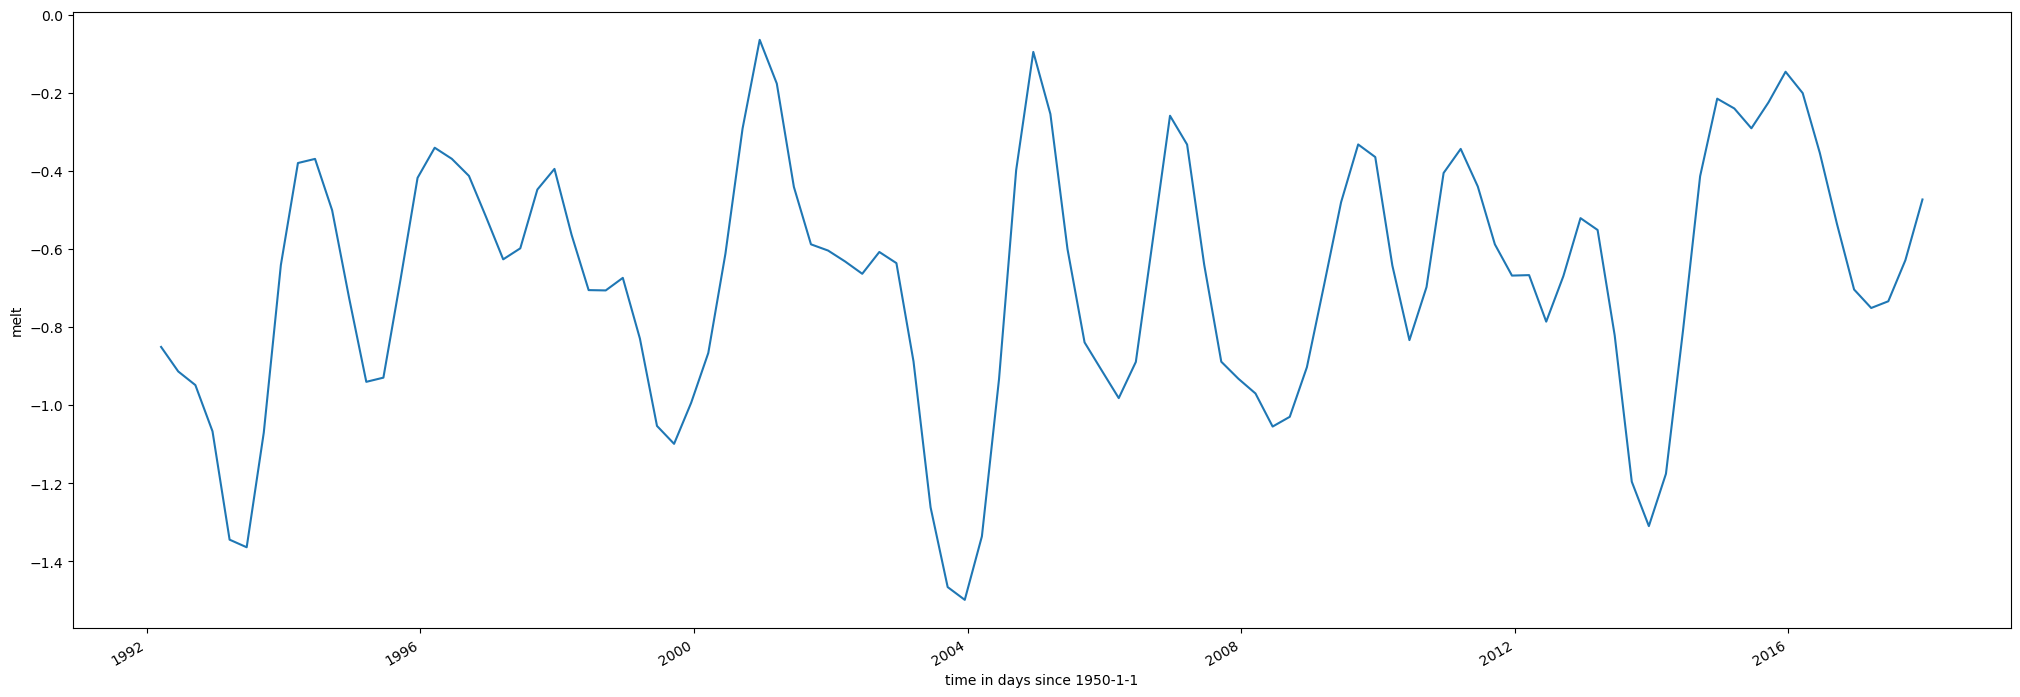

2024-06-23 16:20:06,259 - tornado.application - ERROR - Exception in callback <bound method SystemMonitor.update of <SystemMonitor: cpu: 0 memory: 31 MB fds: 210>>
Traceback (most recent call last):
  File "/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/tornado/ioloop.py", line 921, in _run
    val = self.callback()
  File "/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/distributed/system_monitor.py", line 134, in update
    net_ioc = psutil.net_io_counters()
  File "/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/psutil/__init__.py", line 2114, in net_io_counters
    rawdict = _psplatform.net_io_counters()
OSError: [Errno 12] Cannot allocate memory
ERROR:tornado.application:Exception in callback <bound method SystemMonitor.update of <SystemMonitor: cpu: 0 memory: 31 MB fds: 210>>
Traceback (most recent call last):
  File "/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/tornado/ioloop.

In [3]:
plt.figure(figsize=(25,8))
obs23_melt_ts.plot()
obs23_melt_detrend_uniform_deseasonalize_uniform_ts.plot()
(obs23_melt_ts - obs23_melt_detrend_uniform_deseasonalize_uniform_ts).plot()
plt.legend(['Original', 'Detrended and deseasonalized', 'Difference'])
plt.title('Time series of spatially averaged ice shelf basal melt rate from satellite observations')
plt.ylabel('Melt rate (m/yr)')
plt.xlabel('Time (Year)')
plt.grid()

Text(0.5, 1.0, 'Mean ice shelf basal melt rate from satellite observations (1992-2017)')

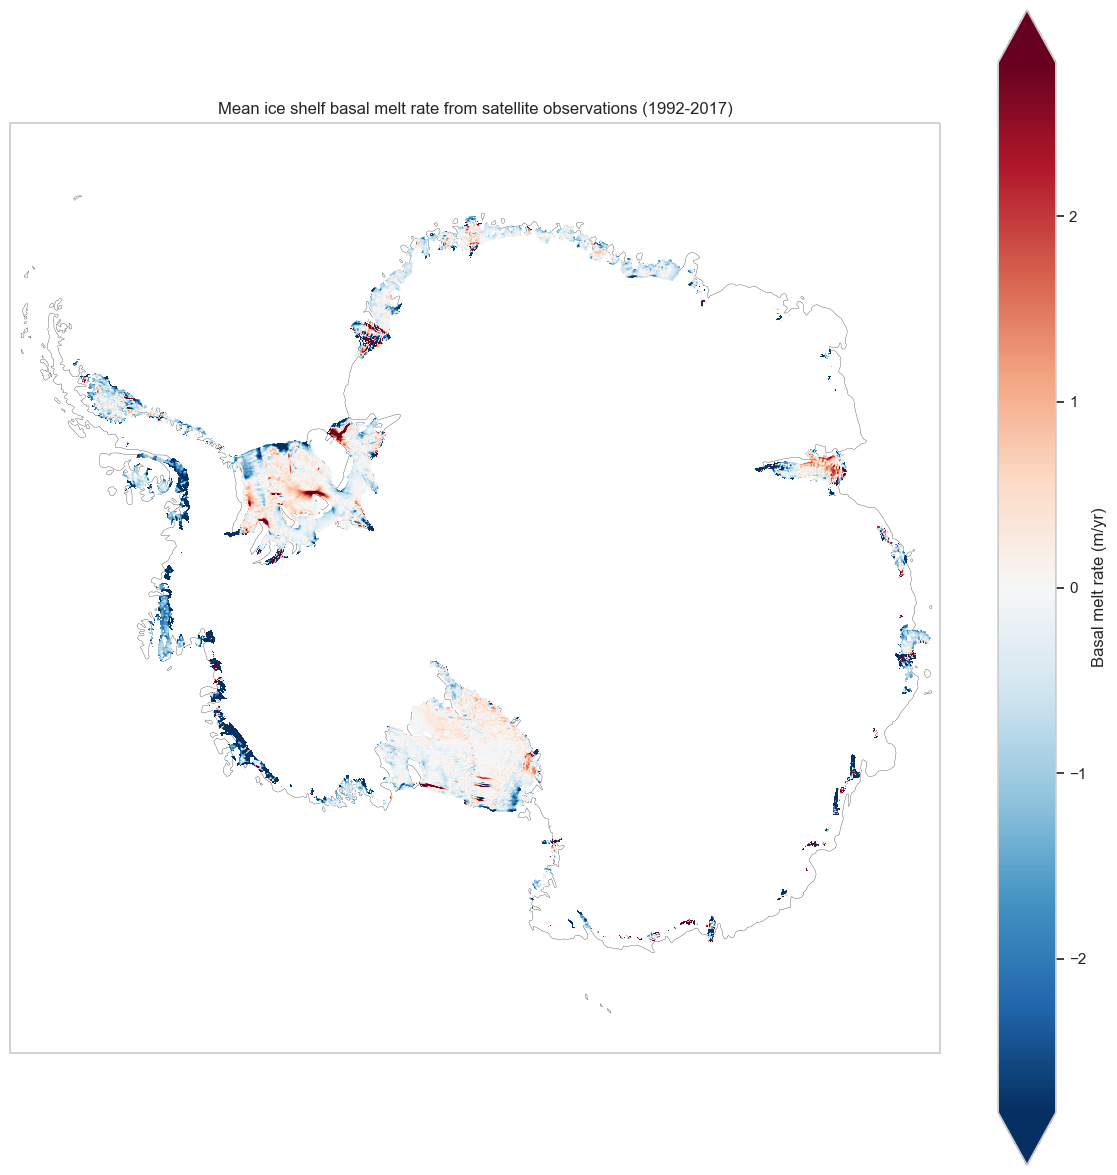

In [17]:
# Note the colorbar extent is set to half of the max of the 1% and 99% quantiles in the raw data variable for better visualization.
obs23_melt_tm_vmin = np.nanquantile(obs23_melt_tm.values, 0.01)
obs23_melt_tm_vmax = np.nanquantile(obs23_melt_tm.values, 0.99)

# Plot figure

sns.set_theme(style="whitegrid")

plt.figure(figsize=(15,15))
ax1 = plt.subplot(111,projection=ccrs.SouthPolarStereo())

#icems[34:133].plot(ax=ax1,color='antiquewhite', linewidth=0,zorder=1)
#icems[34:133].boundary.plot(ax=ax1,color='k', linewidth=0.2,zorder=4)


#ax1.patch.set_facecolor(color='lightsteelblue')
#ax1.add_feature(cartopy.feature.LAND, color='ghostwhite', zorder=1)
ax1.coastlines(lw=0.2)

obs23_melt_tm.plot(ax=ax1, vmin=-abs(obs23_melt_tm_vmin)/4, vmax=abs(obs23_melt_tm_vmin)/4, cmap='RdBu_r', cbar_kwargs={'label': 'Basal melt rate (m/yr)'}, zorder=5)
plt.title('Mean ice shelf basal melt rate from satellite observations (1992-2017)')

Text(0.5, 1.0, 'Ice draft underneath ice shelves (mean during 1992-2017)')

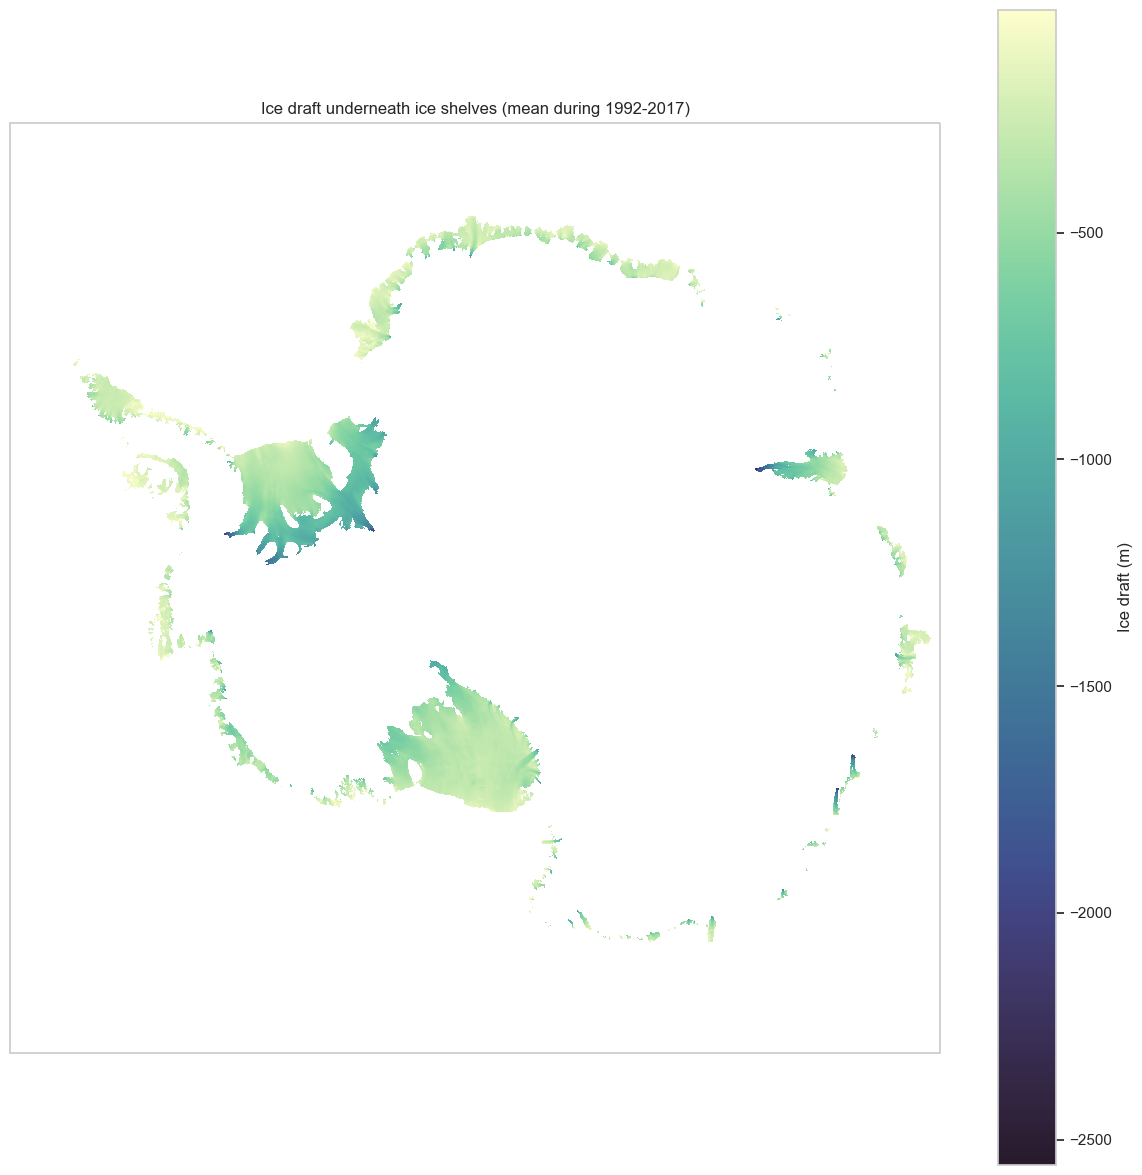

In [3]:
# Note the colorbar extent is set to half of the max of the 1% and 99% quantiles in the raw data variable for better visualization.
sns.set_theme(style="whitegrid")

plt.figure(figsize=(15,15))
ax1 = plt.subplot(111,projection=ccrs.SouthPolarStereo())

#icems[34:133].plot(ax=ax1,color='antiquewhite', linewidth=0,zorder=1)
#icems[34:133].boundary.plot(ax=ax1,color='k', linewidth=0.2,zorder=4)


#ax1.patch.set_facecolor(color='lightsteelblue')
#ax1.add_feature(cartopy.feature.LAND, color='ghostwhite', zorder=1)
# ax1.coastlines(lw=0.2)

(0-obs23_draft_tm).plot(ax=ax1, cmap=cmocean.cm.deep_r, cbar_kwargs={'label': 'Ice draft (m)'}, zorder=5)
plt.title('Ice draft underneath ice shelves (mean during 1992-2017)')

In [19]:
obs23_melt_detrend_uniform_deseasonalize_uniform_ts = obs23_melt_detrend_uniform_deseasonalize_uniform.melt.mean(['x','y']).compute()

2024-06-11 18:31:28,446 - tornado.application - ERROR - Exception in callback <bound method SystemMonitor.update of <SystemMonitor: cpu: 0 memory: 17 MB fds: 36>>
Traceback (most recent call last):
  File "/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/tornado/ioloop.py", line 921, in _run
    val = self.callback()
  File "/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/distributed/system_monitor.py", line 134, in update
    net_ioc = psutil.net_io_counters()
  File "/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/psutil/__init__.py", line 2114, in net_io_counters
    rawdict = _psplatform.net_io_counters()
OSError: [Errno 12] Cannot allocate memory
2024-06-11 18:31:28,446 - tornado.application - ERROR - Exception in callback <bound method SystemMonitor.update of <SystemMonitor: cpu: 0 memory: 17 MB fds: 36>>
Traceback (most recent call last):
  File "/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/s

## Detrend dataset

The satellite observational dataset of basal melt rate is fit to a linear polynomial function to remove any inherent trend.

Interestingly, there is a bump in the linear trend in 2012 that should be explained, using Method 1 (naive).

The methodology for detrending has been tested/verified to be correct.

### Method 1 (*Per-pixel*)
Detrend the time series of spatial mean melt rate using a linear trend that is unique at each spatial point.

A first order polynomial fit is performed **on the raw 3 dimensional dataset** and this fit is subtracted from all pixel locations in the data.


### Method 2 (*Uniform*)
Detrend the time series of spatial mean melt rate using a mean linear trend that is uniform at all spatial points.

A first order polynomial fit (linear decomposition) is performed **on the spatially averaged dataset** (i.e., essentially a time series data), and this same fit is subtracted from all locations in the data.

In [23]:
def detrend_dim(data, dim, deg):
    # detrend along a single dimension
    p = data.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(data[dim], p.polyfit_coefficients)
    return data - fit

#### Detrend Method 1 (per-pixel)

In [6]:
# Method 1: Detrend the time series of spatial mean melt rate using a linear trend that is unique at each spatial point
obs23_melt_detrend_perpixel = detrend_dim(obs23_melt, 'time', 1).compute()
obs23_melt_detrend_perpixel_ts = obs23_melt_detrend_perpixel.mean(dim=['x', 'y']).compute()

KeyboardInterrupt: 

#### Detrend Method 2 (uniform)

In [444]:
# Method 2: Detrend the time series of spatial mean melt rate using a mean linear trend that is uniform at all spatial points
obs23_melt_detrend_ts = detrend_dim(obs23_melt_ts, 'time', 1).compute()
trendfit = obs23_melt_ts-obs23_melt_detrend_ts
# Subtract the above trendfit from the melt dataset to get the detrended melt dataset
obs23_melt_detrend_uniform = obs23_melt - trendfit
obs23_melt_detrend_uniform_ts = obs23_melt_detrend_uniform.mean(dim=['x', 'y']).compute()

#### Compare detrend methods

NameError: name 'obs23_melt_detrend_perpixel_ts' is not defined

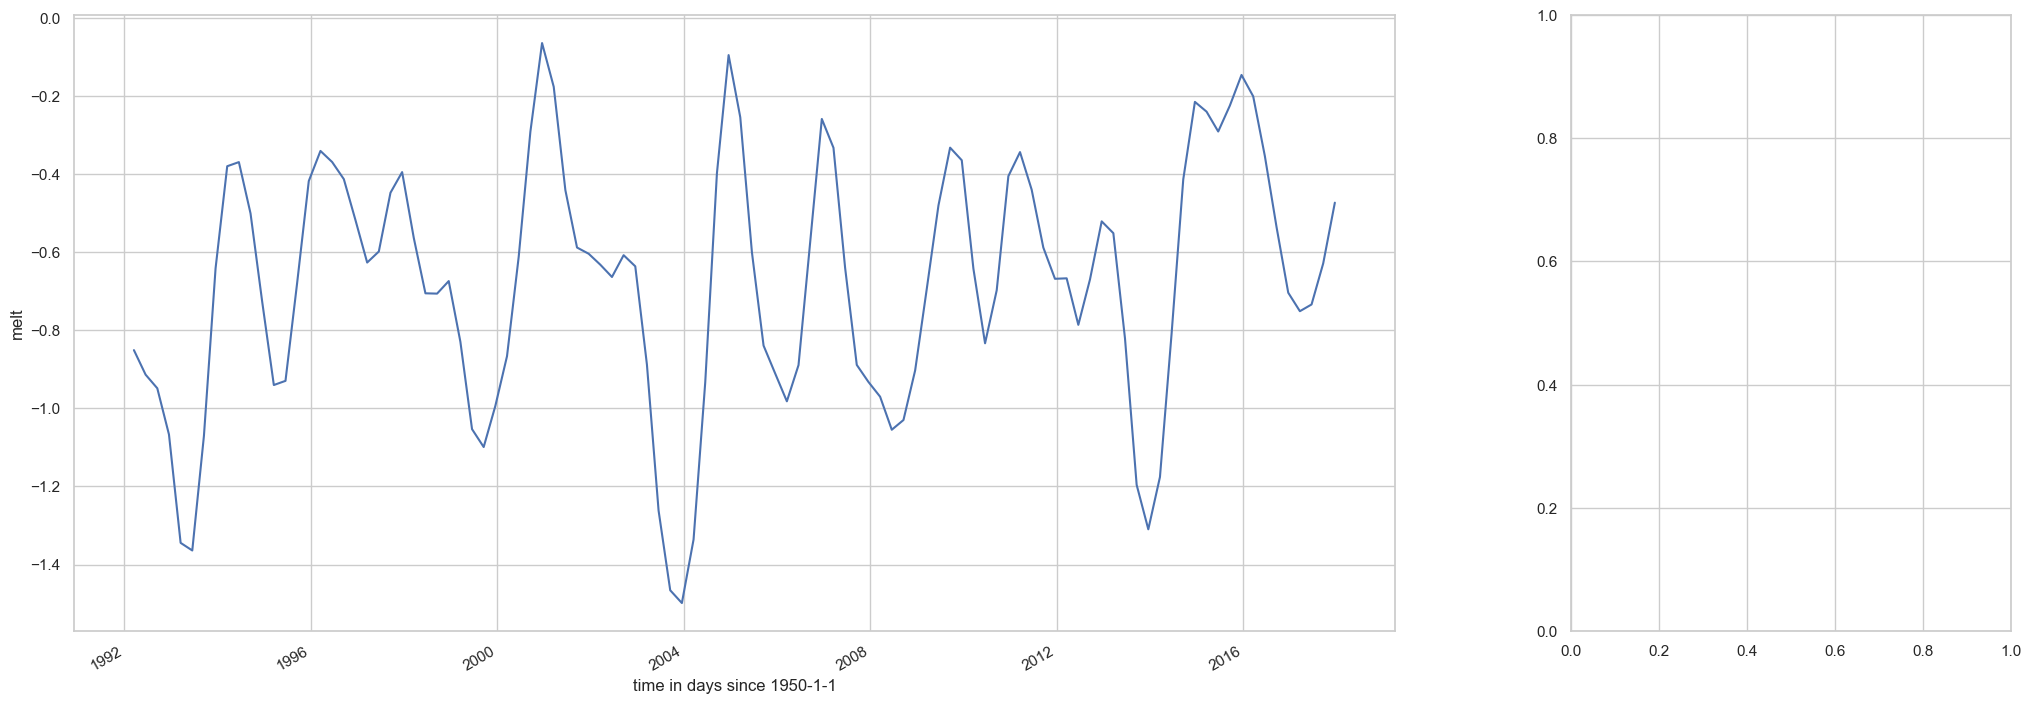

In [42]:
plt.subplots(1,2,figsize=(25,8), gridspec_kw={'width_ratios': [3, 1]})

plt.subplot(121)
obs23_melt_ts.plot(label='Original')
obs23_melt_detrend_perpixel_ts.plot(label='Detrended')
(obs23_melt_ts-obs23_melt_detrend_perpixel_ts).plot(label='Linear Function Fit', lw=3, ls='--')
plt.title('Time series of spatially averaged ice shelf basal melt rate from satellite observations (detrended)')
plt.xlabel('Time (Year)')
plt.ylabel('Melt rate (m/yr)')
plt.axvspan(pd.Timestamp('2011-10-01'), pd.Timestamp('2012-05-01'), facecolor='red', alpha=0.2, label='Jump in melt rate trend?!')
plt.legend()

plt.subplot(122)
plt.plot(obs23_melt_ts-obs23_melt_detrend_perpixel_ts, lw=3, ls='--', color='green')
plt.xlabel('Time (Date Index)')
plt.ylabel('Melt rate (m/yr)')
plt.title('Linear function fit for the melt rate time series trend')

NameError: name 'obs23_melt_detrend_perpixel_ts' is not defined

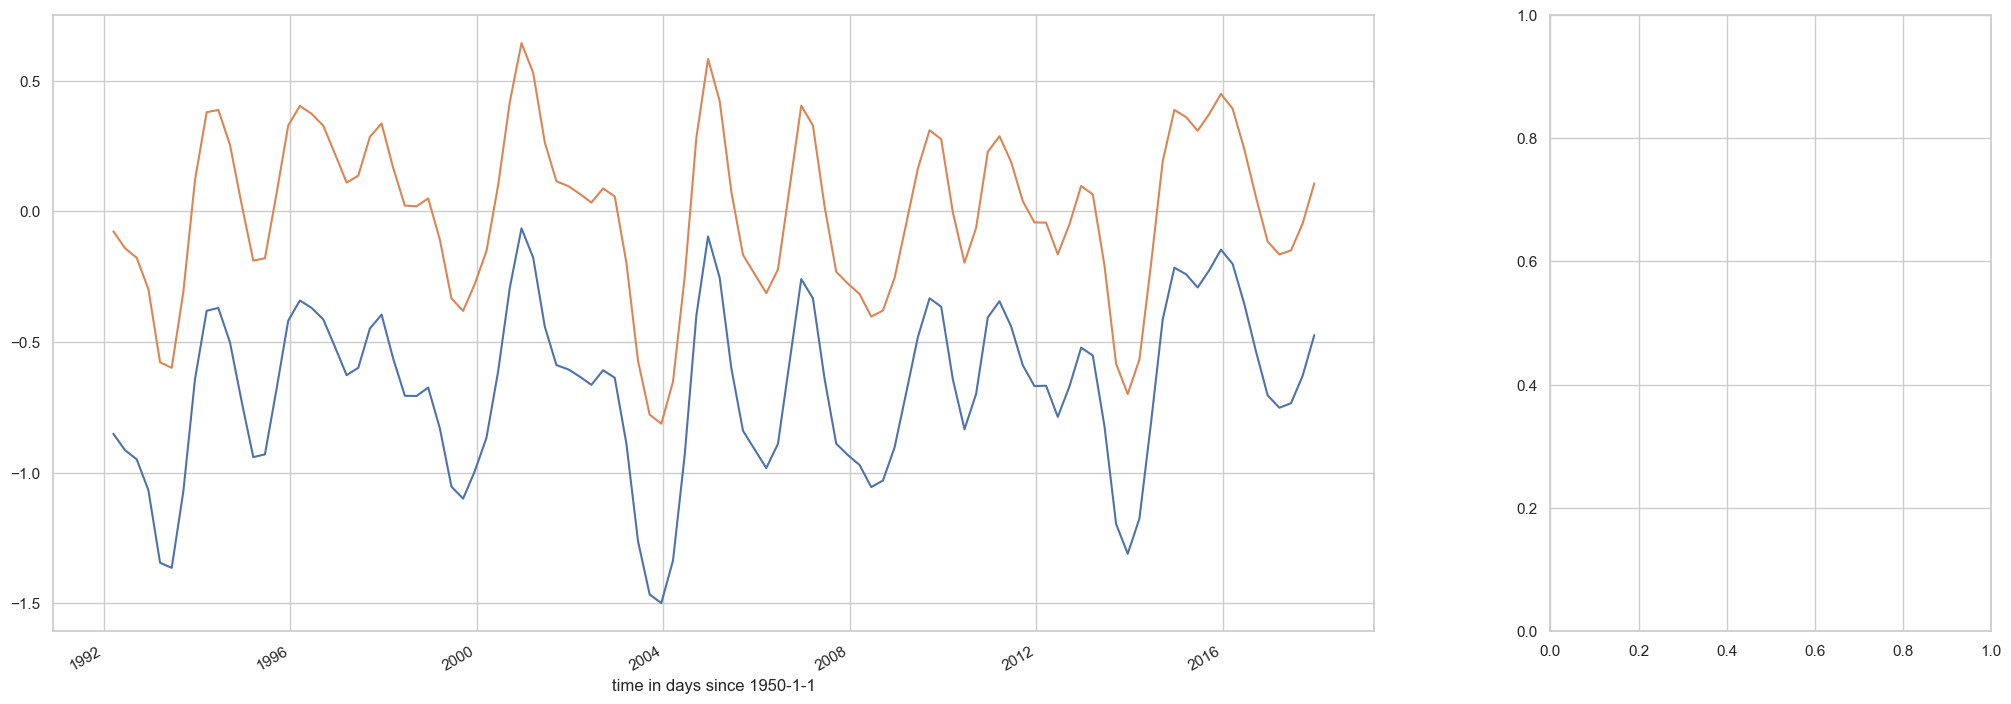

In [43]:
plt.subplots(1,2,figsize=(25,8), gridspec_kw={'width_ratios': [3, 1]})

plt.subplot(121)
obs23_melt_ts.plot(label='Original')
obs23_melt_detrend_uniform_ts.plot(label='Detrended with uniform linear trend across ice sheet')
obs23_melt_detrend_perpixel_ts.plot(label='Detrended with linear trend on a per-pixel basis')
(obs23_melt_ts-obs23_melt_detrend_uniform_ts).plot(label='Linear Function Fit (uniform)', lw=3, ls='-')
(obs23_melt_ts-obs23_melt_detrend_perpixel_ts).plot(label='Linear Function Fit (per-pixel)', lw=3, ls='--')
(obs23_melt_detrend_uniform_ts-obs23_melt_detrend_perpixel_ts).plot(label='Difference between the two detrending methods', lw=3, ls=':')
plt.title('Time series of spatially averaged ice shelf basal melt rate from satellite observations')
plt.xlabel('Time (Year)')
plt.ylabel('Melt rate (m/yr)')
plt.legend()

plt.subplot(122)
(obs23_melt_ts-obs23_melt_detrend_uniform_ts).plot(label='Linear Function Fit (uniform)', lw=3, ls='-', color='C3') # uniform linear trend subtracted
(obs23_melt_ts-obs23_melt_detrend_perpixel_ts).plot(label='Linear Function Fit (per-pixel)', lw=3, ls='--', color='C4') # per-pixel linear trend subtracted
plt.xlabel('Time (Date Index)')
plt.ylabel('Melt rate (m/yr)')
plt.title('Linear function fit for the melt rate time series trend')

## RENAME

# obs23_melt_detrend_tmp_ts -> obs23_melt_detrend_uniform_ts
# obs23_melt_detrend_ts -> obs23_melt_detrend_perpixel_ts


We proceed with the detrending using **Method 2**, as it provides a "cleaner" trendline fit without the jump in 2012 for further pre-processing.

## Deseasonalize

Seasonal climatologies can be removed via two methods similar to the initial detrending step.
(1) On a per-pixel basis
(2) A uniform/average climatology

#### Deseasonalize Method 1 (per-pixel)

In [8]:
# Deseasonalize
# Remove climatologies to isolate anomalies / deseasonalize 
melt_month = obs23_melt_detrend_uniform.groupby("time.month")
melt_clm = melt_month.mean("time")#.compute() # Climatologies
obs23_melt_detrend_uniform_deseasonalize = melt_month - melt_clm # Deseasonalized anomalies

#### Deseasonalize Method 2 (uniform)

In [43]:
# Deseasonalize with a uniform/average climatology

melt_month = obs23_melt_detrend_uniform_ts.groupby("time.month")
melt_clm = melt_month.mean("time")#.compute() # Climatologies
obs23_melt_detrend_uniform_deseasonalize_ts = melt_month - melt_clm # Deseasonalized anomalies

climfit = obs23_melt_detrend_uniform_ts - obs23_melt_detrend_uniform_deseasonalize_ts
obs23_melt_detrend_uniform_deseasonalize_uniform = obs23_melt_detrend_uniform - climfit

#### Save dedrended and deseasonalized dataset
For future steps and iterations, we load this dataset into the notebook (done in the read dataset section above)

In [47]:
obs23_melt_detrend_uniform_deseasonalize_uniform.attrs['detrend_method'] = 'uniform linear trend across ice sheet'
obs23_melt_detrend_uniform_deseasonalize_uniform.attrs['deseason_method'] = 'uniform climatology across ice sheet'
obs23_melt_detrend_uniform_deseasonalize_uniform = obs23_melt_detrend_uniform_deseasonalize_uniform.rename('melt')

In [41]:
obs23_melt_detrend_uniform_deseasonalize.to_netcdf(main_dir / DIR_processed / "obs23_melt_detrend_uniform_deseasonalize.nc", engine='h5netcdf')
obs23_melt_detrend_uniform_deseasonalize_uniform.to_netcdf(main_dir / DIR_processed / "obs23_melt_detrend_uniform_deseasonalize_uniform.nc", engine='h5netcdf')

#### Compute spatially averaged time series for the detrended and deseasonalized data

In [26]:
obs23_melt_detrend_uniform_deseasonalize_uniform_ts = obs23_melt_detrend_uniform_deseasonalize_uniform.mean(dim=['x', 'y']).compute()

In [31]:
obs23_melt_detrend_uniform_deseasonalize_uniform_ts = obs23_melt_detrend_uniform_deseasonalize_uniform_ts.melt
obs23_melt_detrend_uniform_deseasonalize_uniform = obs23_melt_detrend_uniform_deseasonalize_uniform.melt

In [28]:
trend = obs23_melt_ts - obs23_melt_detrend_uniform_ts
clim = obs23_melt_detrend_uniform_ts-obs23_melt_detrend_uniform_deseasonalize_uniform_ts

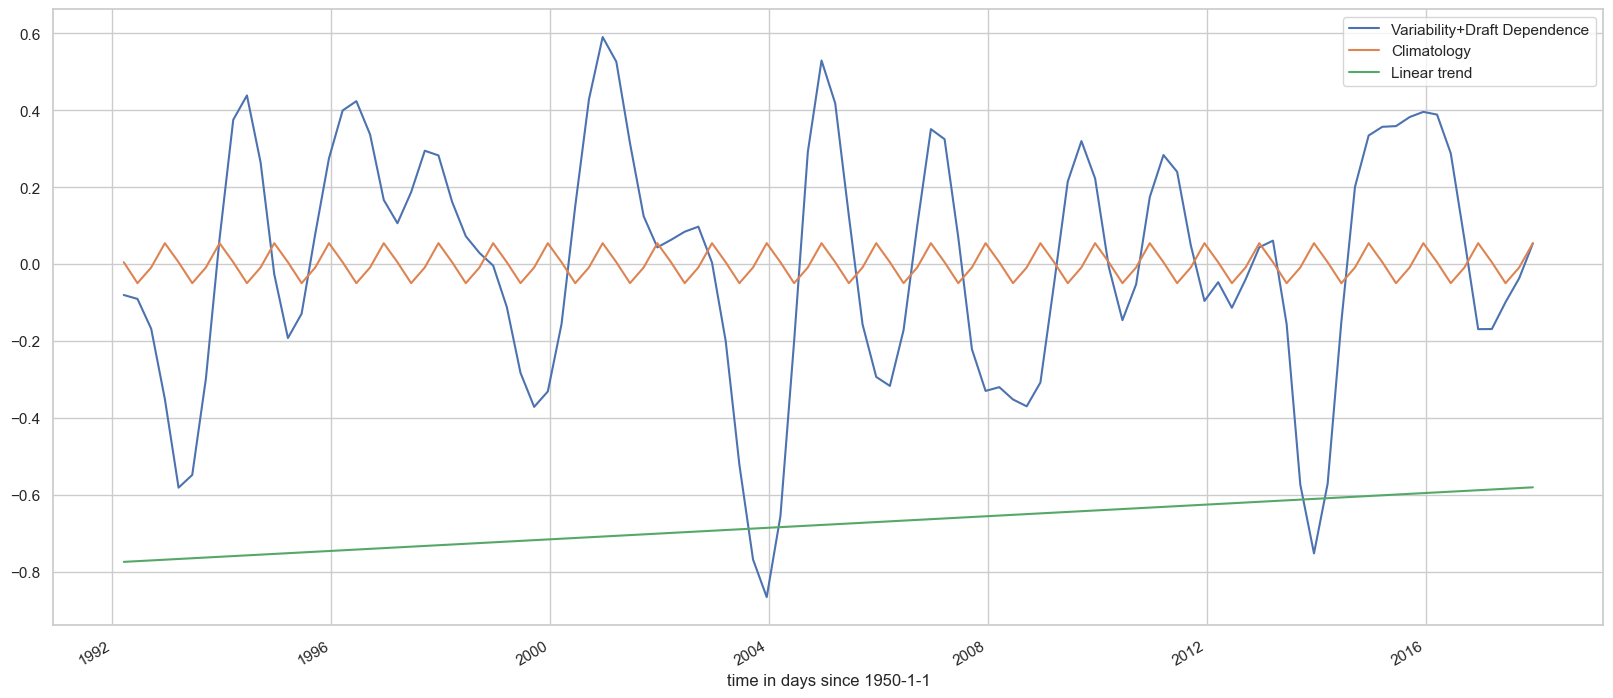

In [73]:
plt.figure(figsize=(20,8))
obs23_melt_detrend_uniform_deseasonalize_uniform_ts.plot(label='Variability+Draft Dependence')
#obs23_melt_detrend_uniform_ts.plot()
(obs23_melt_detrend_uniform_ts-obs23_melt_detrend_uniform_deseasonalize_uniform_ts).plot(label='Climatology')
(obs23_melt_ts-obs23_melt_detrend_uniform_ts).plot(label='Linear trend')

plt.legend()


#### Melt variability anomalies (naive method)

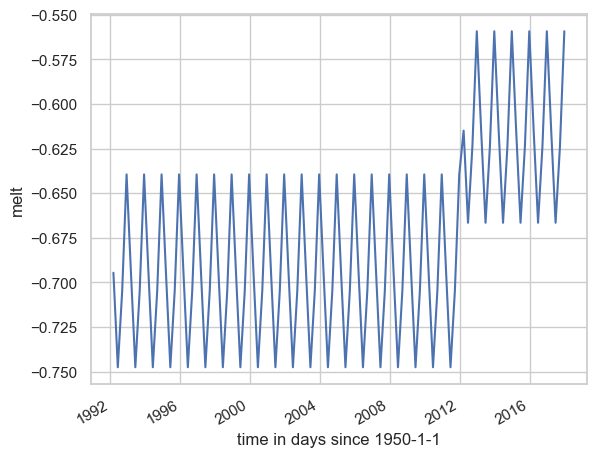

In [74]:
# Remove seasonality from the time series
# Check draft dependence on the residuals
# Check the residuals for spatial correlation

obs23_melt_anm = xr.open_dataset(main_dir / DIR_processed / FILE_basalMeltObs_deSeasonalized, chunks={"x":729, "y":729})
obs23_melt_anm_ts = obs23_melt_anm.melt.mean(dim=['x', 'y']).compute()

#obs23_melt_anm_ts.plot()
#obs23_melt_ts.plot()
(obs23_melt_ts-obs23_melt_anm_ts).plot()



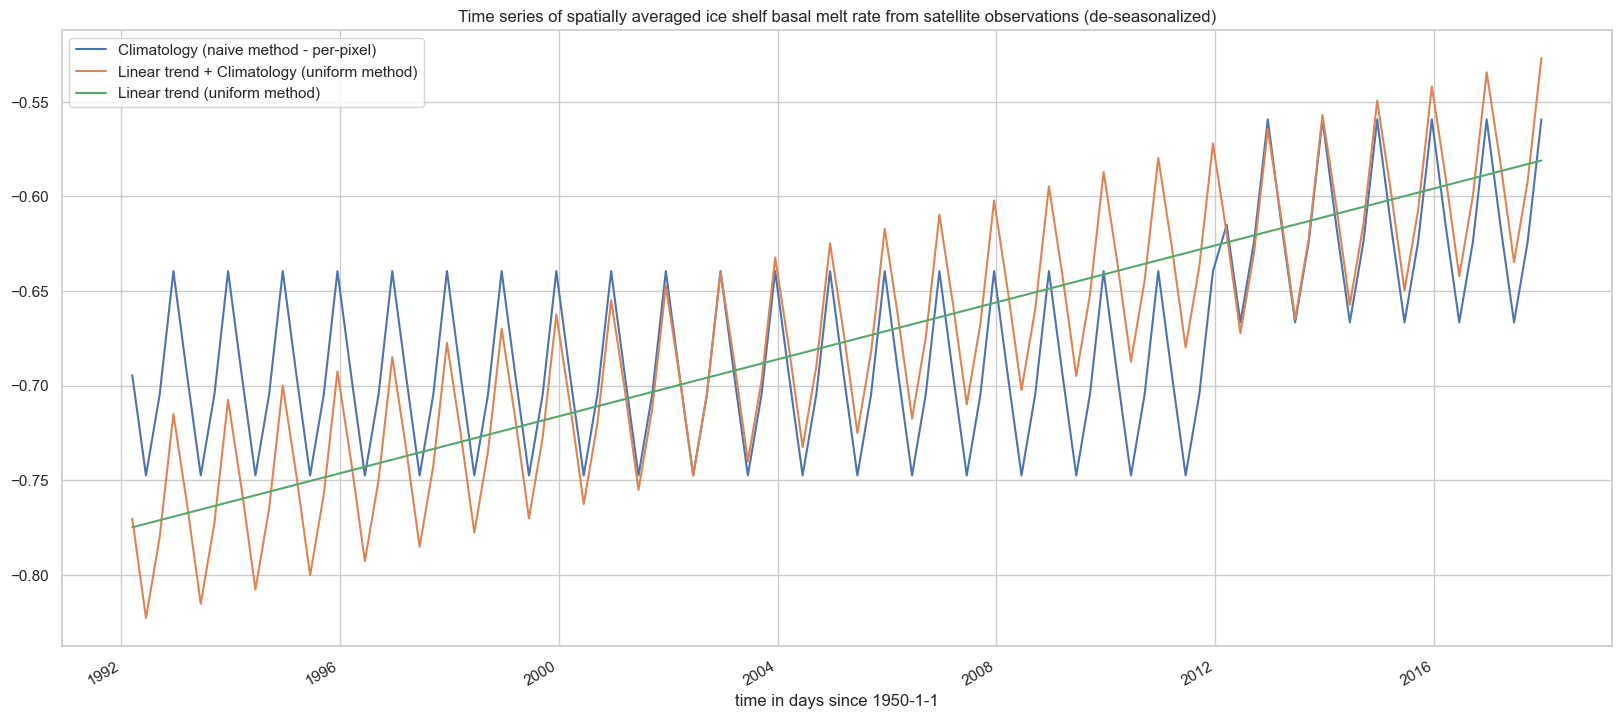

In [102]:
plt.figure(figsize=(20,8))
(obs23_melt_ts-obs23_melt_anm_ts).plot(label='Climatology (naive method - per-pixel)')
(clim.melt+trendfit).plot(label='Linear trend + Climatology (uniform method)')
trendfit.plot(label='Linear trend (uniform method)')
plt.title('Time series of spatially averaged ice shelf basal melt rate from satellite observations (de-seasonalized)')
#(-clim.melt+obs23_melt_ts-obs23_melt_anm_ts).plot()
plt.legend()

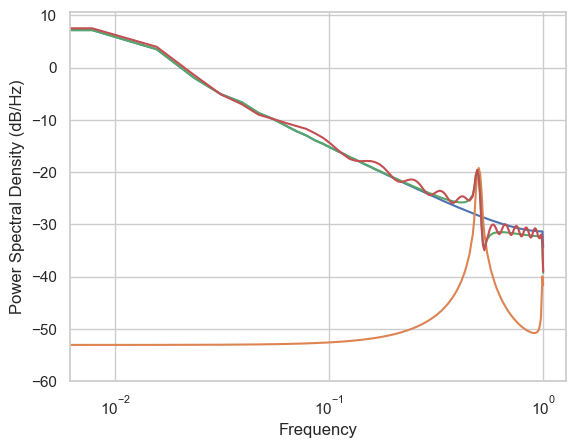

In [82]:
plt.psd(trendfit);
plt.psd(clim.melt);
plt.psd(trendfit+clim.melt);
plt.xscale('log')
plt.psd(obs23_melt_ts-obs23_melt_anm_ts);

(2500.0, 0.0)

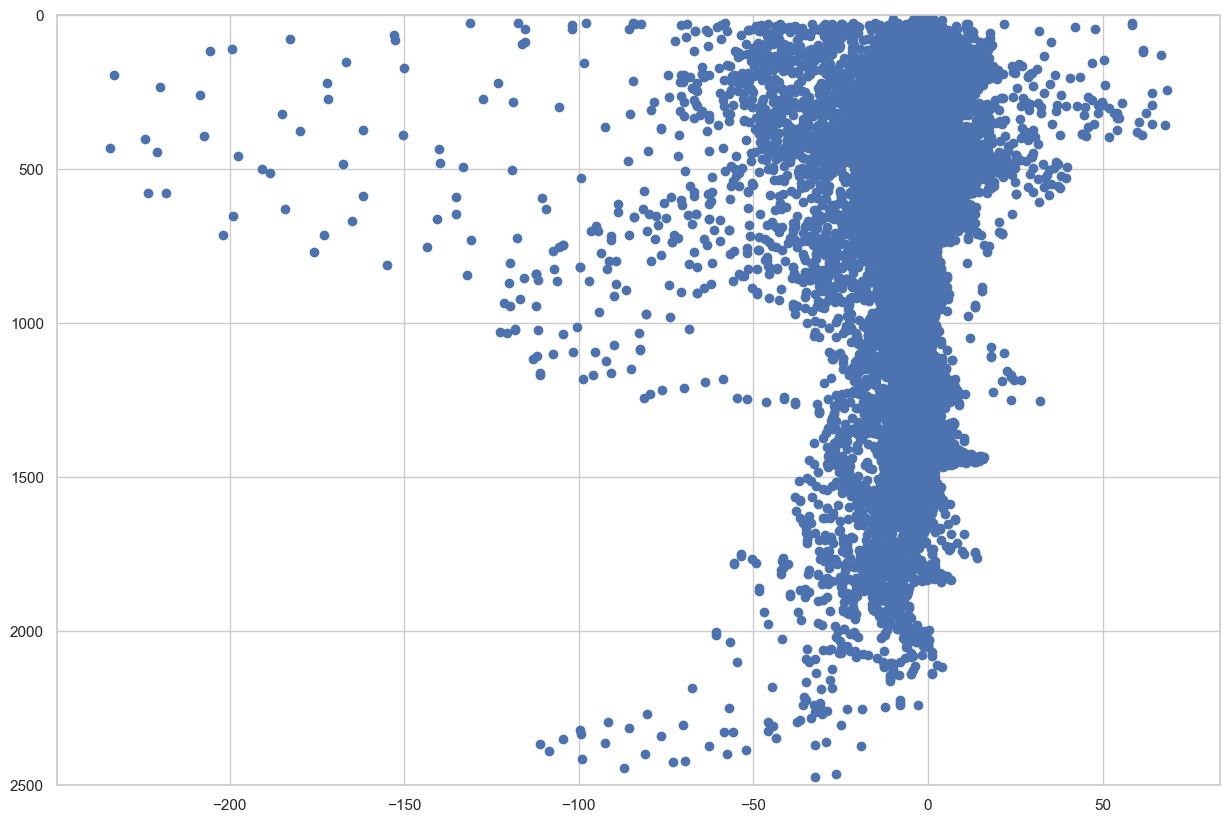

In [79]:
plt.figure(figsize=(15,10))
plt.scatter(obs23_melt_tm, obs23_draft_tm)
plt.ylim(2500,0)

In [ ]:
# Deseasonalize: Remove climatologies to isolate anomalies / deseasonalize
obs23_melt_month = obs23_melt.groupby("time.month")
obs23_melt_clm = obs23_melt_month.mean("time").compute() # Climatologies
obs23_melt_anm = (obs23_melt_month - obs23_melt_clm).compute() # Deseasonalized anomalies

In [ ]:
obs23_melt_anm_ts = obs23_melt_anm.mean(['x', 'y']).compute()

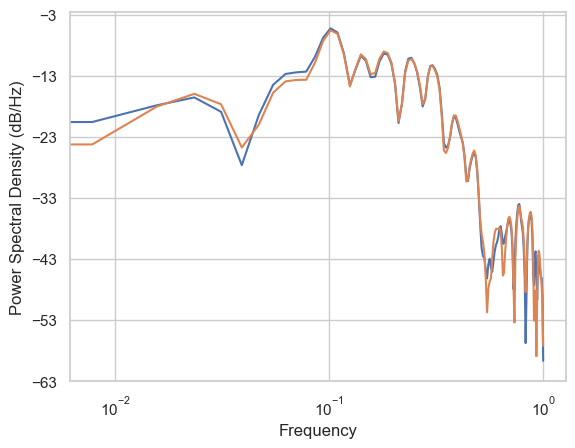

In [104]:
plt.psd(obs23_melt_anm_ts);
plt.psd(obs23_melt_detrend_uniform_deseasonalize_uniform_ts);
plt.xscale('log')

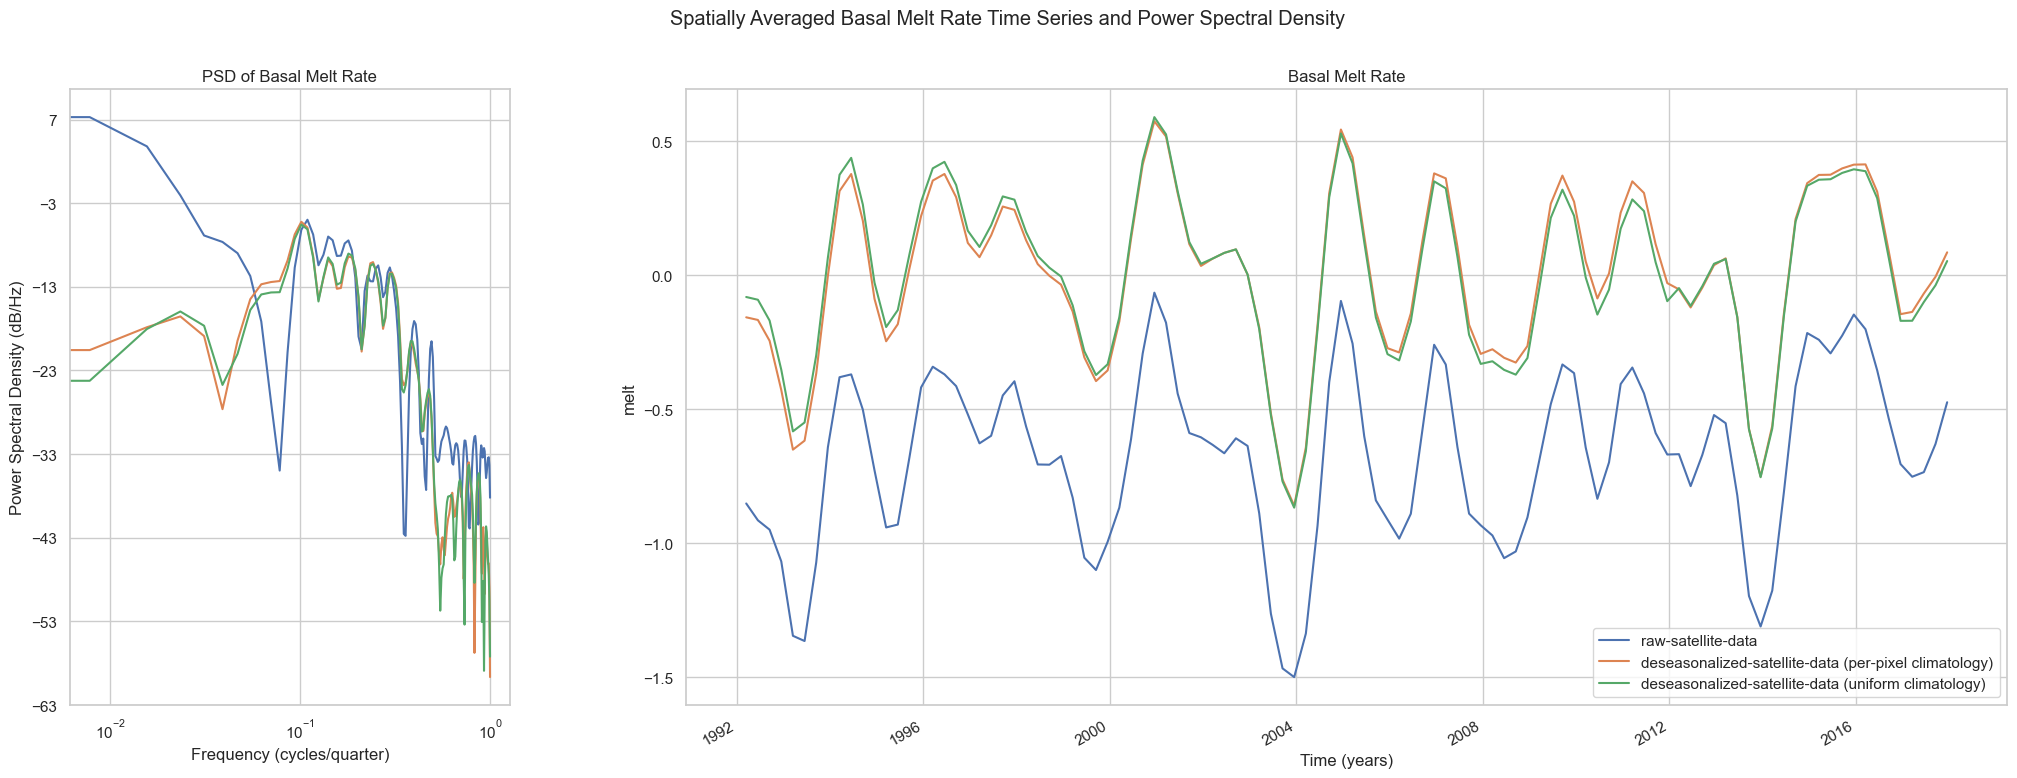

In [92]:
fig, axs = plt.subplots(1, 2, figsize=(25, 8), gridspec_kw={'width_ratios': [1, 3]})

axs[0].psd(obs23_melt_ts);
axs[0].psd(obs23_melt_anm_ts);
axs[0].psd(obs23_melt_detrend_uniform_deseasonalize_uniform_ts);
axs[0].set_xlabel('Frequency (cycles/quarter)')
axs[0].set_xscale('log')
axs[0].set_title('PSD of Basal Melt Rate')

obs23_melt_ts.plot(ax=axs[1], label='raw-satellite-data')
obs23_melt_anm_ts.plot(ax=axs[1], label='deseasonalized-satellite-data (per-pixel climatology)')
obs23_melt_detrend_uniform_deseasonalize_uniform_ts.plot(ax=axs[1], label='deseasonalized-satellite-data (uniform climatology)')
#axs[1].plot(obs23_melt_ts)
axs[1].set_xlabel('Time (years)')
axs[1].set_title('Basal Melt Rate')

plt.legend()
fig.suptitle('Spatially Averaged Basal Melt Rate Time Series and Power Spectral Density')
plt.show()

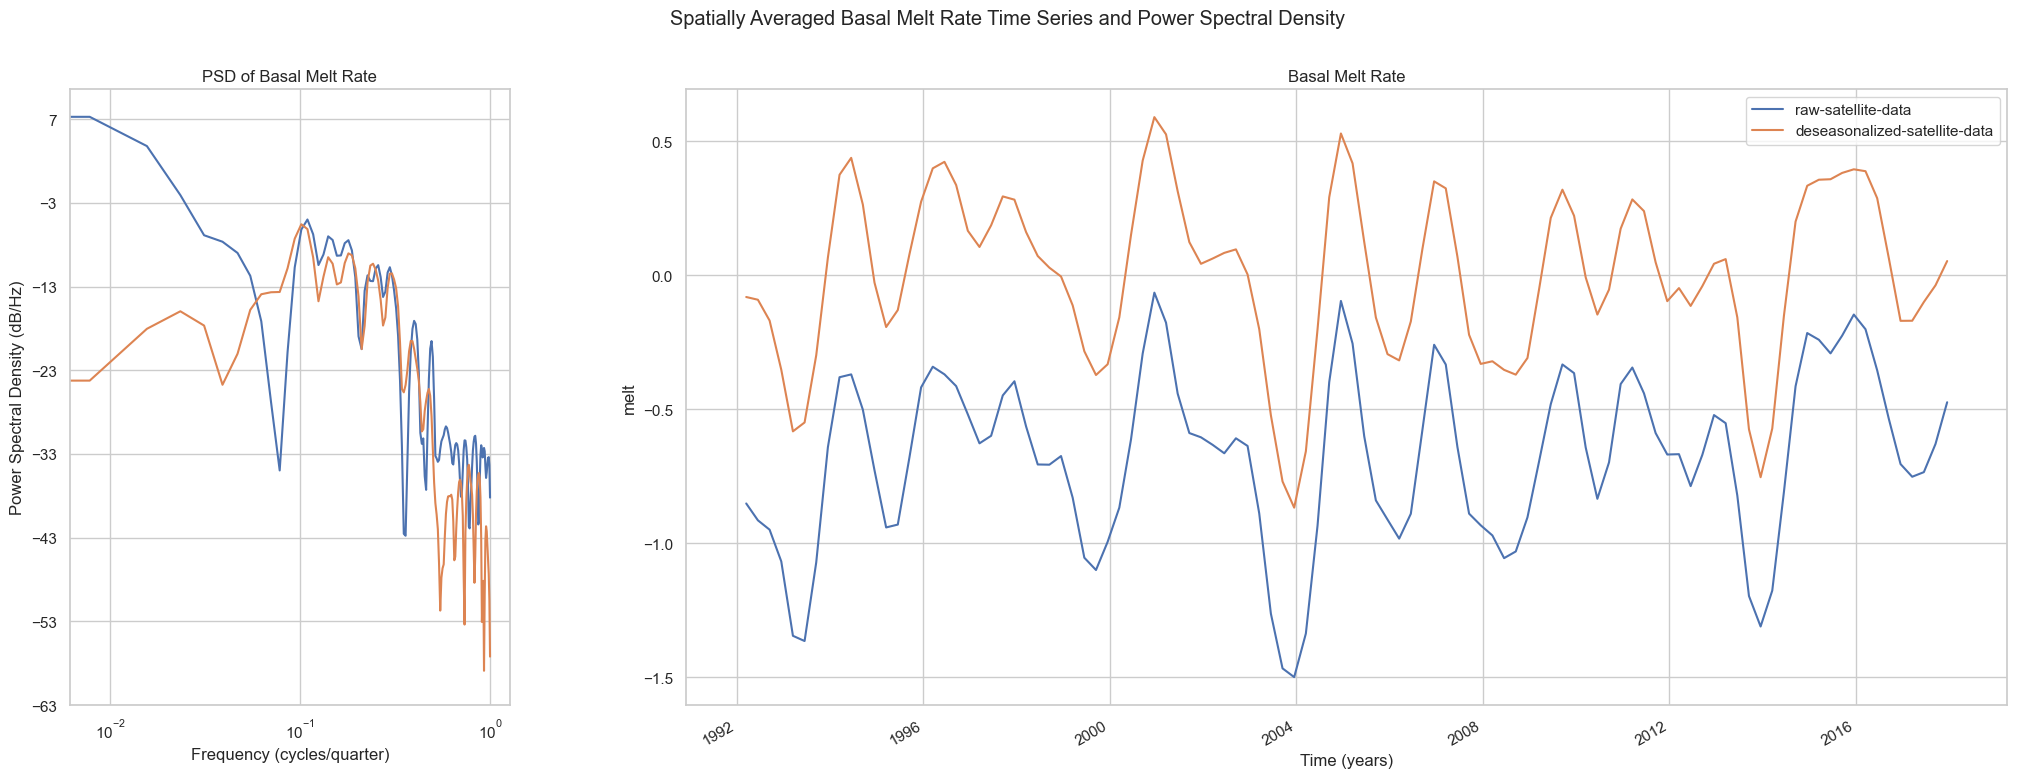

In [87]:
fig, axs = plt.subplots(1, 2, figsize=(25, 8), gridspec_kw={'width_ratios': [1, 3]})

axs[0].psd(obs23_melt_ts);
axs[0].psd(obs23_melt_detrend_uniform_deseasonalize_uniform_ts);
axs[0].set_xlabel('Frequency (cycles/quarter)')
axs[0].set_xscale('log')
axs[0].set_title('PSD of Basal Melt Rate')

obs23_melt_ts.plot(ax=axs[1], label='raw-satellite-data')
obs23_melt_detrend_uniform_deseasonalize_uniform_ts.plot(ax=axs[1], label='deseasonalized-satellite-data')
#axs[1].plot(obs23_melt_ts)
axs[1].set_xlabel('Time (years)')
axs[1].set_title('Basal Melt Rate')

plt.legend()
fig.suptitle('Spatially Averaged Basal Melt Rate Time Series and Power Spectral Density')
plt.show()

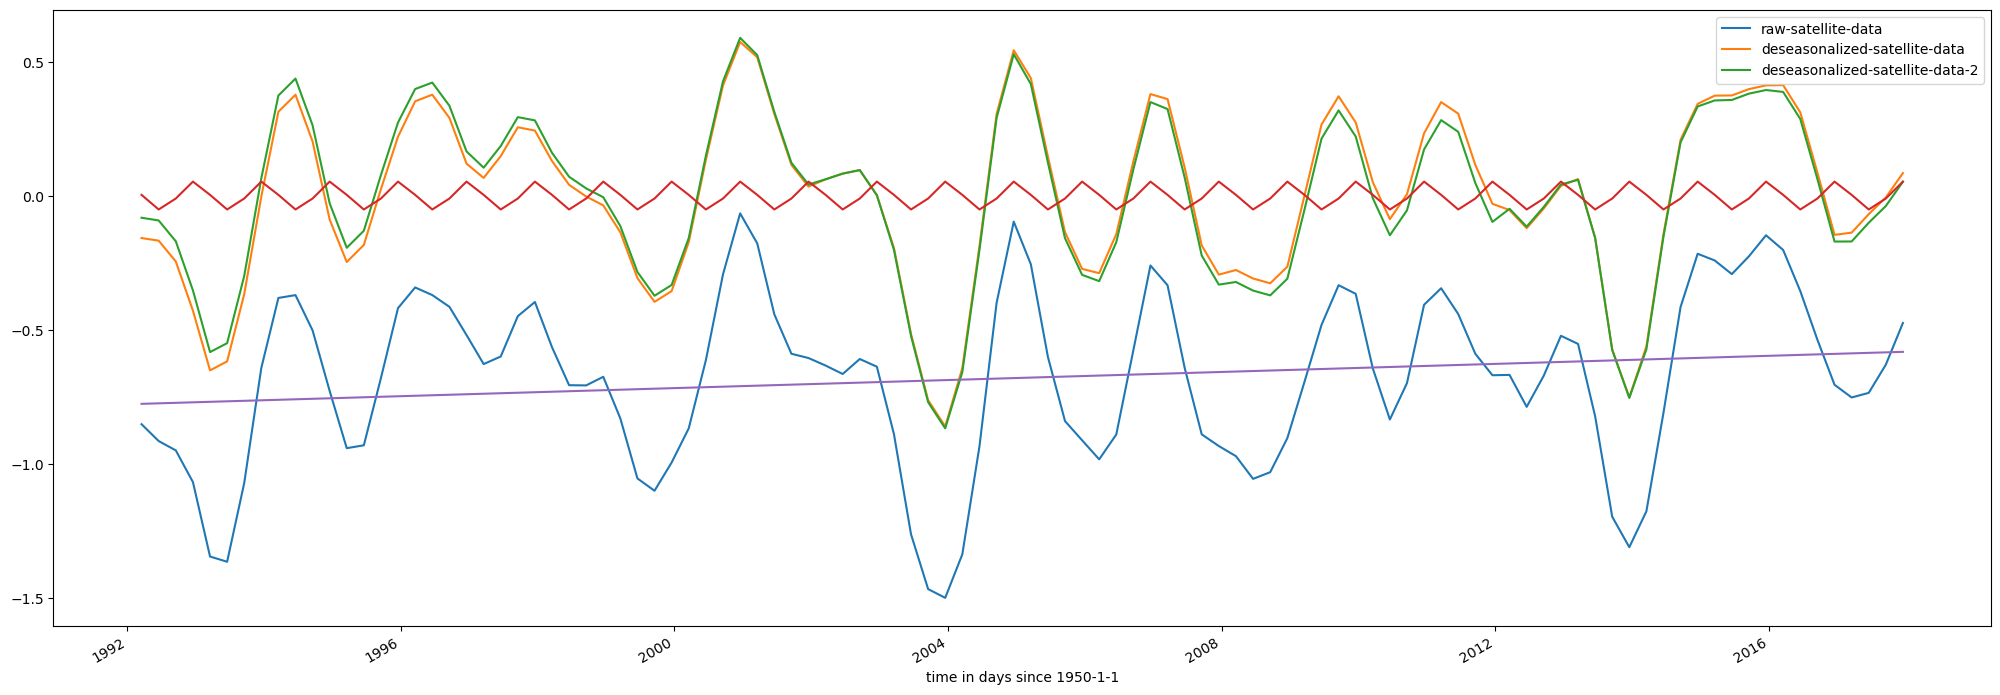

In [86]:
plt.figure(figsize=(25,8))
obs23_melt_ts.plot(label='raw-satellite-data')
obs23_melt_anm_ts.plot(label='deseasonalized-satellite-data')
obs23_melt_detrend_uniform_deseasonalize_uniform_ts.plot(label='deseasonalized-satellite-data-2')
#(obs23_melt_ts - obs23_melt_anm_ts).plot(label='climatology')
climfit.plot()
trendfit.plot()
#axs[1].plot(obs23_melt_ts)
axs[1].set_xlabel('Time (years)')
axs[1].set_title('Basal Melt Rate')

plt.legend()

## Dedraft
We now clip the data to specific ice shelves.

In [5]:
def clip_data(total_data, basin):
    clipped_data = total_data.rio.clip(icems.loc[[basin],'geometry'].apply(mapping),icems.crs)
    #clipped_data = clipped_data.dropna('time',how='all')
    #clipped_data = clipped_data.dropna('y',how='all')
    #clipped_data = clipped_data.dropna('x',how='all')
    #clipped_data = clipped_data.drop("month")
    return clipped_data

In [10]:
obs23_melt_tm.rio.write_crs("epsg:3031",inplace=True);
obs23_draft_tm.rio.write_crs("epsg:3031",inplace=True);
obs23_draft.rio.write_crs("epsg:3031",inplace=True);
obs23_melt_detrend_uniform_deseasonalize_uniform.rio.write_crs("epsg:3031",inplace=True);
obs23_melt_detrend_uniform.rio.write_crs("epsg:3031",inplace=True);

NameError: name 'obs23_melt_detrend_uniform' is not defined

In [47]:
obs23_melt_detrend_uniform_deseasonalize_uniform_tm = obs23_melt_detrend_uniform_deseasonalize_uniform.mean(dim='time').compute()

In [7]:
icems.name.values

array(['Filchner-Ronne', 'Ross', 'Antarctica', 'Peninsula',
       'West Antarctica', 'East Antarctica', 'IMBIE1', 'IMBIE2', 'IMBIE3',
       'IMBIE4', 'IMBIE5', 'IMBIE6', 'IMBIE7', 'IMBIE8', 'IMBIE9',
       'IMBIE10', 'IMBIE11', 'IMBIE12', 'IMBIE13', 'IMBIE14', 'IMBIE15',
       'IMBIE16', 'IMBIE17', 'IMBIE18', 'IMBIE19', 'IMBIE20', 'IMBIE21',
       'IMBIE22', 'IMBIE23', 'IMBIE24', 'IMBIE25', 'IMBIE26', 'IMBIE27',
       'Abbot', 'Amery', 'Atka', 'Aviator', 'Bach', 'Baudouin',
       'Borchgrevink', 'Brahms', 'Brunt_Stancomb', 'Campbell', 'Cheetham',
       'Conger_Glenzer', 'Cook', 'Cosgrove', 'Crosson', 'Dennistoun',
       'Dibble', 'Dotson', 'Drygalski', 'Edward_VIII', 'Ekstrom',
       'Ferrigno', 'Filchner', 'Fimbul', 'Fitzgerald', 'Frost',
       'GeikieInlet', 'George_VI', 'Getz', 'Gillet', 'Hamilton', 'Hannan',
       'HarbordGlacier', 'Helen', 'Holmes', 'HolmesWest', 'Hull',
       'Jelbart', 'Land', 'Larsen_B', 'Larsen_C', 'Larsen_D', 'Larsen_E',
       'Larsen_F', 'Larse

In [4]:
# given ice shelf name, find the index number in icems
def find_ice_shelf_index(ice_shelf_name):
    return icems[icems['name']==ice_shelf_name].index[0]



In [8]:
i = find_ice_shelf_index('Thwaites')
# obs23_melt_detrend_uniform_deseasonalize_uniform = obs23_melt_detrend_uniform_deseasonalize_uniform.melt

mlt = clip_data(obs23_melt_detrend_uniform_deseasonalize_uniform_tm, i)
h = clip_data(obs23_draft_tm, i)

# Reshape mlt and h data for linear regression
mlt_stack = mlt.stack(z=('x', 'y'))#.values.reshape(-1,1)
h_stack = h.stack(z=('x', 'y'))#.values.reshape(-1,1)

mlt_stack_noNaN = mlt_stack.fillna(0)
h_stack_noNaN = h_stack.fillna(0)

mlt_stack_noNaN_vals = mlt_stack_noNaN.values.reshape(-1,1)
h_stack_noNaN_vals = h_stack_noNaN.values.reshape(-1,1)

# X is the independent variable, y is the dependent variable
# X is the ice draft, y is the melt rate
X = h_stack_noNaN_vals
y = mlt_stack_noNaN_vals
reg = LinearRegression().fit(X,y)
print("X is:")
print(X)
print("Shape of X is: {}".format(X.shape))
print("Coefficient (slope) is: ")
print(reg.coef_)
print("Intercept is: ")
print(reg.intercept_)
print("y is:")
print(y)
#print("Predicted y for X = [3,5] is:")
#print(reg.predict(np.array([[3,5]])))

NameError: name 'obs23_melt_detrend_uniform_deseasonalize_uniform_tm' is not defined

In [29]:
i = find_ice_shelf_index('Getz')
# obs23_melt_detrend_uniform_deseasonalize_uniform = obs23_melt_detrend_uniform_deseasonalize_uniform.melt

mlt = clip_data(obs23_melt_tm, i)
h = clip_data(obs23_draft_tm, i)

# Reshape mlt and h data for linear regression
mlt_stack = mlt.stack(z=('x', 'y'))#.values.reshape(-1,1)
h_stack = h.stack(z=('x', 'y'))#.values.reshape(-1,1)

mlt_stack_noNaN = mlt_stack.fillna(0)
h_stack_noNaN = h_stack.fillna(0)

mlt_stack_noNaN_vals = mlt_stack_noNaN.values.reshape(-1,1)
h_stack_noNaN_vals = h_stack_noNaN.values.reshape(-1,1)

# X is the independent variable, y is the dependent variable
# X is the ice draft, y is the melt rate
X = h_stack_noNaN_vals
y = mlt_stack_noNaN_vals
reg = LinearRegression().fit(X,y)
print("X is:")
print(X)
print("Shape of X is: {}".format(X.shape))
print("Coefficient (slope) is: ")
print(reg.coef_)
print("Intercept is: ")
print(reg.intercept_)
print("y is:")
print(y)
#print("Predicted y for X = [3,5] is:")
#print(reg.predict(np.array([[3,5]])))

X is:
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
Shape of X is: (129360, 1)
Coefficient (slope) is: 
[[-0.00927342]]
Intercept is: 
[-0.00094041]
y is:
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]


In [30]:
# Model predicted value array for melt rate, i.e., the draft dependent component of the melt rate
y_pred = reg.predict(X)
mlt_pred_stack_noNaN_vals = y_pred.reshape(-1)
# Create a new xarray DataArray with the predicted melt rate values
mlt_pred_stack_noNaN = mlt_stack_noNaN.copy(data=mlt_pred_stack_noNaN_vals)
# Place NaN values in mlt_pred_stack based on the location of NaN values in mlt_stack
mlt_pred_stack = mlt_pred_stack_noNaN.where(~mlt_stack.isnull(), np.nan)
# Reshape the predicted melt rate DataArray to the original shape of the ice shelf
mlt_pred = mlt_pred_stack.unstack('z').transpose()

#print("Shape of h: {}".format(h.shape))
print("Shape of mlt: {}".format(mlt.shape))
print("Shape of mlt_stack: {}".format(mlt_stack.shape))
print("Shape of mlt_stack_noNaN: {}".format(mlt_stack_noNaN.shape))
print("Shape of mlt_stack_noNaN_vals: {}".format(mlt_stack_noNaN_vals.shape))
print("Shape of mlt_pred_stack_noNaN_vals: {}".format(mlt_pred_stack_noNaN_vals.shape))
print("Shape of mlt_pred_stack_noNaN: {}".format(mlt_pred_stack_noNaN.shape))
print("Shape of mlt_pred_stack: {}".format(mlt_pred_stack.shape))
print("Shape of mlt_pred: {}".format(mlt_pred.shape))

Shape of mlt: (294, 440)
Shape of mlt_stack: (129360,)
Shape of mlt_stack_noNaN: (129360,)
Shape of mlt_stack_noNaN_vals: (129360, 1)
Shape of mlt_pred_stack_noNaN_vals: (129360,)
Shape of mlt_pred_stack_noNaN: (129360,)
Shape of mlt_pred_stack: (129360,)
Shape of mlt_pred: (294, 440)


(2500.0, 0.0)

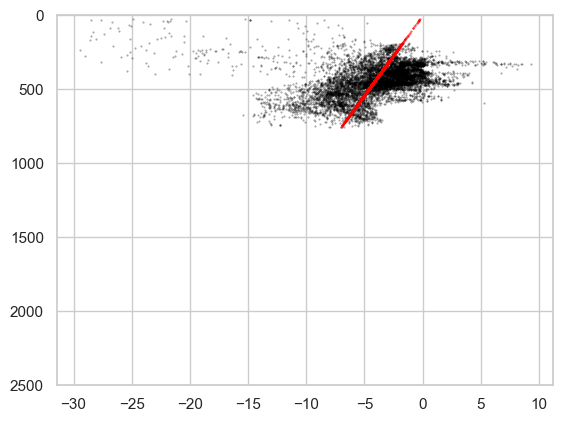

In [36]:
plt.scatter(mlt, h, color='black', alpha=0.4, s=0.2)
plt.scatter(mlt_pred, h, color='red', alpha=0.4, s=0.2)
plt.ylim(2500,0)

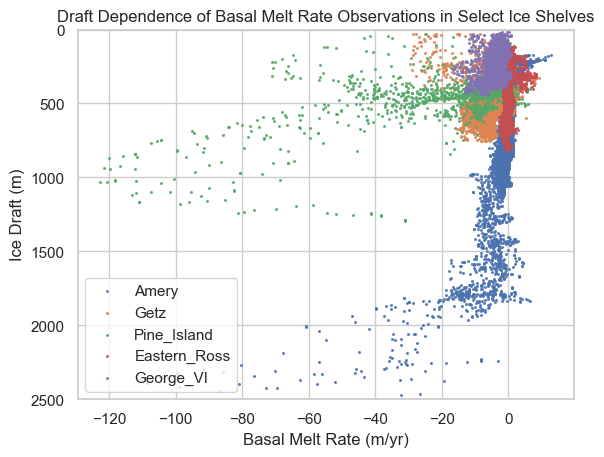

2024-08-14 18:26:05,280 - tornado.application - ERROR - Exception in callback <bound method SystemMonitor.update of <SystemMonitor: cpu: 0 memory: 15 MB fds: 31>>
Traceback (most recent call last):
  File "/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/tornado/ioloop.py", line 921, in _run
    val = self.callback()
  File "/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/distributed/system_monitor.py", line 134, in update
    net_ioc = psutil.net_io_counters()
  File "/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/psutil/__init__.py", line 2114, in net_io_counters
    rawdict = _psplatform.net_io_counters()
OSError: [Errno 12] Cannot allocate memory
2024-08-14 19:02:50,825 - tornado.application - ERROR - Exception in callback <bound method SystemMonitor.update of <SystemMonitor: cpu: 0 memory: 22 MB fds: 214>>
Traceback (most recent call last):
  File "/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/

In [51]:
ice_shelves_for_figure = ['Amery', 'Getz', 'Pine_Island', 'Eastern_Ross', 'George_VI']
for shelfname in ice_shelves_for_figure:
    i = find_ice_shelf_index(shelfname)
    # obs23_melt_detrend_uniform_deseasonalize_uniform = obs23_melt_detrend_uniform_deseasonalize_uniform.melt

    mlt = clip_data(obs23_melt_tm, i)
    h = clip_data(obs23_draft_tm, i)

    # Reshape mlt and h data for linear regression
    mlt_stack = mlt.stack(z=('x', 'y'))#.values.reshape(-1,1)
    h_stack = h.stack(z=('x', 'y'))#.values.reshape(-1,1)

    mlt_stack_noNaN = mlt_stack.fillna(0)
    h_stack_noNaN = h_stack.fillna(0)

    mlt_stack_noNaN_vals = mlt_stack_noNaN.values.reshape(-1,1)
    h_stack_noNaN_vals = h_stack_noNaN.values.reshape(-1,1)

    # X is the independent variable, y is the dependent variable
    # X is the ice draft, y is the melt rate
    X = h_stack_noNaN_vals
    y = mlt_stack_noNaN_vals
    reg = LinearRegression().fit(X,y)


    # Model predicted value array for melt rate, i.e., the draft dependent component of the melt rate
    y_pred = reg.predict(X)
    mlt_pred_stack_noNaN_vals = y_pred.reshape(-1)
    # Create a new xarray DataArray with the predicted melt rate values
    mlt_pred_stack_noNaN = mlt_stack_noNaN.copy(data=mlt_pred_stack_noNaN_vals)
    # Place NaN values in mlt_pred_stack based on the location of NaN values in mlt_stack
    mlt_pred_stack = mlt_pred_stack_noNaN.where(~mlt_stack.isnull(), np.nan)
    # Reshape the predicted melt rate DataArray to the original shape of the ice shelf
    mlt_pred = mlt_pred_stack.unstack('z').transpose()
    plt.scatter(mlt, h, alpha=0.8, s=1.5, label=shelfname)
    #plt.scatter(mlt_pred, h, color='black', alpha=0.4, s=0.2)
    plt.ylim(2500,0)


plt.xlabel('Basal Melt Rate (m/yr)')
plt.ylabel('Ice Draft (m)')
plt.title('Draft Dependence of Basal Melt Rate Observations in Select Ice Shelves')
plt.legend(loc='lower left')


In [507]:
# Remove mlt_pred from mlt to get the residuals, which we assume as the remaining variability in the melt rate that is not explained by the ice draft

mlt_full = clip_data(obs23_melt_detrend_uniform_deseasonalize_uniform, i)
mlt_full_dedraft = mlt_full - mlt_pred

mlt_full_ts = mlt_full.mean(dim=['x', 'y']).compute()
mlt_full_dedraft_ts = mlt_full_dedraft.mean(dim=['x', 'y']).compute()

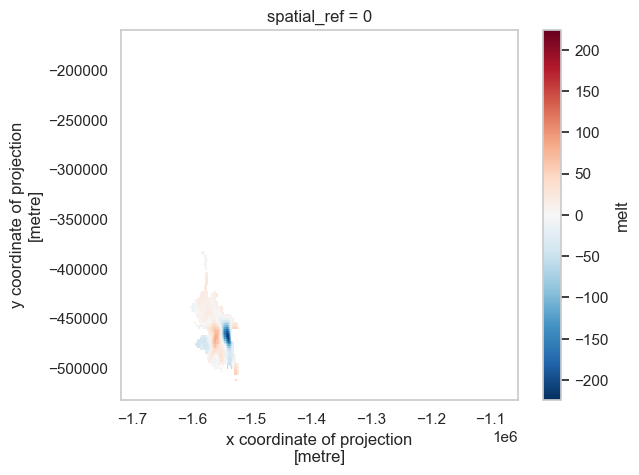

In [508]:
mlt_full_dedraft_tm = mlt_full_dedraft.mean(dim='time').compute()
mlt_full_dedraft_tm.plot()

In [509]:
#climfit = obs23_melt_detrend_uniform_ts - obs23_melt_detrend_uniform_deseasonalize_uniform_ts
obs23_melt_detrend_uniform.rio.write_crs("epsg:3031",inplace=True);
mlt_detrend = clip_data(obs23_melt_detrend_uniform, i)
mlt_detrend_deseasonalize = clip_data(obs23_melt_detrend_uniform_deseasonalize_uniform, i)
mlt_detrend_ts = mlt_detrend.mean(dim=['x', 'y']).compute()
mlt_detrend_deseasonalize_ts = mlt_detrend_deseasonalize.mean(dim=['x', 'y']).compute()
mlt_clim = mlt_detrend_ts - mlt_full_ts

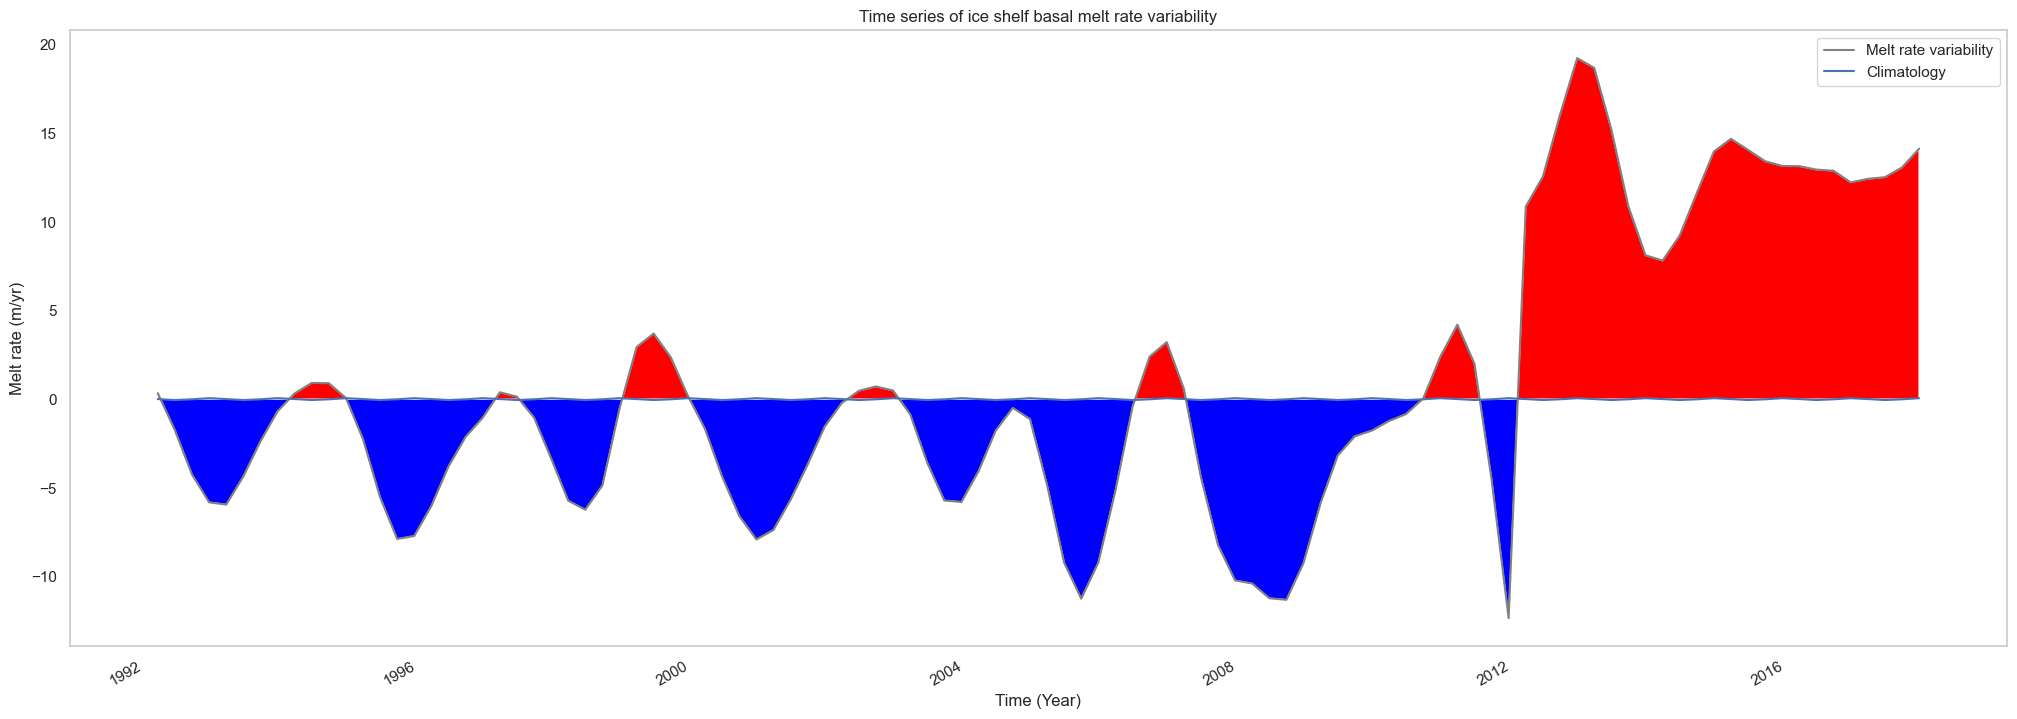

ERROR:tornado.application:Exception in callback <bound method SystemMonitor.update of <SystemMonitor: cpu: 0 memory: 52 MB fds: 337>>
Traceback (most recent call last):
  File "/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/tornado/ioloop.py", line 921, in _run
    val = self.callback()
  File "/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/distributed/system_monitor.py", line 134, in update
    net_ioc = psutil.net_io_counters()
  File "/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/psutil/__init__.py", line 2114, in net_io_counters
    rawdict = _psplatform.net_io_counters()
OSError: [Errno 12] Cannot allocate memory
2024-05-01 20:43:40,420 - tornado.application - ERROR - Exception in callback <bound method SystemMonitor.update of <SystemMonitor: cpu: 0 memory: 52 MB fds: 337>>
Traceback (most recent call last):
  File "/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/tornado/ioloop.

In [510]:
# Plot the time series of the melt rate variability at the deepest point in the ice shelf
plt.figure(figsize=(25,8))
#mlt_full_ts.plot(label='Total melt rate variability')
#obs23_melt_detrend_uniform_deseasonalize_uniform_ts.plot(label='Deseasonalized melt rate')
#obs23_melt_ts.plot(label='Raw melt rate')
#climfit.plot(label='Climatology')
mlt_full_dedraft_ts.plot(color='grey', label='Melt rate variability')
# mlt_detrend_ts.plot(label='Detrended melt rate')
(mlt_clim).plot(label='Climatology')
#plt.axhline(0, color='black', lw=1.5)
plt.title('Time series of ice shelf basal melt rate variability')

# Fill positive values in the melt rate variability with red color and negative values with blue color
# Fill space between the two curves with a light grey color
plt.fill_between(mlt_full_dedraft_ts.time.values, 0, mlt_full_dedraft_ts, where=mlt_full_dedraft_ts >= 0, facecolor='red', interpolate=True)
plt.fill_between(mlt_full_dedraft_ts.time.values, 0, mlt_full_dedraft_ts, where=mlt_full_dedraft_ts <= 0, facecolor='blue', interpolate=True)

plt.xlabel('Time (Year)')
plt.ylabel('Melt rate (m/yr)')
plt.legend()
plt.grid()

In [ ]:
# Plot the time series of the melt rate variability at the deepest point in the ice shelf
plt.figure(figsize=(25,8))
#mlt_full_ts.plot(label='Total melt rate variability')
#obs23_melt_detrend_uniform_deseasonalize_uniform_ts.plot(label='Deseasonalized melt rate')
#obs23_melt_ts.plot(label='Raw melt rate')
#climfit.plot(label='Climatology')
mlt_full_dedraft_ts.plot(color='grey', label='Melt rate variability')
# mlt_detrend_ts.plot(label='Detrended melt rate')
(mlt_clim+climfit).plot(label='Climatology')
#plt.axhline(0, color='black', lw=1.5)
plt.title('Time series of ice shelf basal melt rate variability')

# Fill positive values in the melt rate variability with red color and negative values with blue color
# Fill space between the two curves with a light grey color
plt.fill_between(mlt_full_dedraft_ts.time.values, 0, mlt_full_dedraft_ts, where=mlt_full_dedraft_ts >= 0, facecolor='red', interpolate=True)
plt.fill_between(mlt_full_dedraft_ts.time.values, 0, mlt_full_dedraft_ts, where=mlt_full_dedraft_ts <= 0, facecolor='blue', interpolate=True)

plt.xlabel('Time (Year)')
plt.ylabel('Melt rate (m/yr)')
plt.legend()
plt.grid()


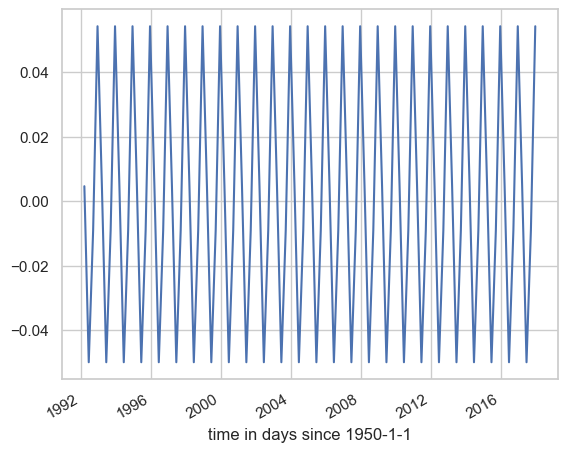

In [474]:
(climfit).plot(label='Climatology')

In [420]:
mlt_pred = xr.DataArray(mlt_pred, coords=mlt.coords, dims=mlt.dims)


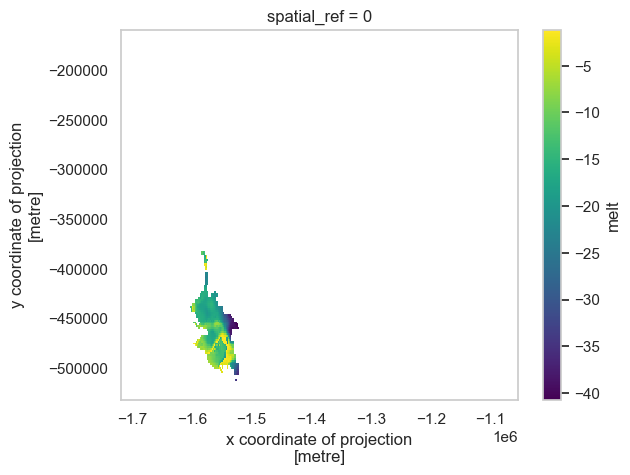

In [421]:
mlt_pred.plot()


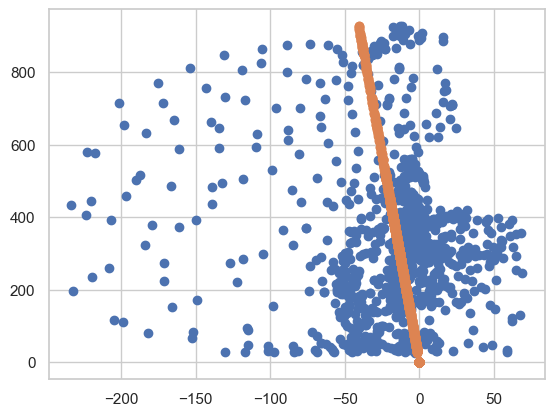

In [422]:
plt.scatter(mlt, h)
plt.scatter(reg.predict(X), X)

In [149]:
model = LinearRegression().fit(mlt_stack_noNaN_vals,h_stack_noNaN_vals)

## Alternate method
### 1. Detrend: Linear (uniform at all spatial points) 
### 2. Clip data to ice shelf
###     2.1. Deseasonalize (for each ice shelf)
###     2.2. Dedraft (for each ice shelf)



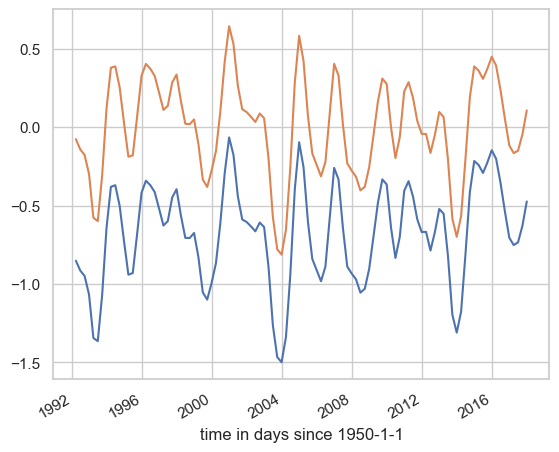

In [428]:
obs23_melt_ts.plot()
obs23_melt_detrend_uniform_ts.plot()


In [430]:
obs23_melt_detrend_uniform_tm = obs23_melt_detrend_uniform.mean(dim='time').compute()

In [441]:
# A function that removes climatologies to isolate anomalies / deseasonalize
def deseasonalize(data):
    data_month = data.groupby("time.month")
    data_clm = data_month.mean("time") # Climatologies
    data_anm = data_month - data_clm # Deseasonalized anomalies
    return data_anm

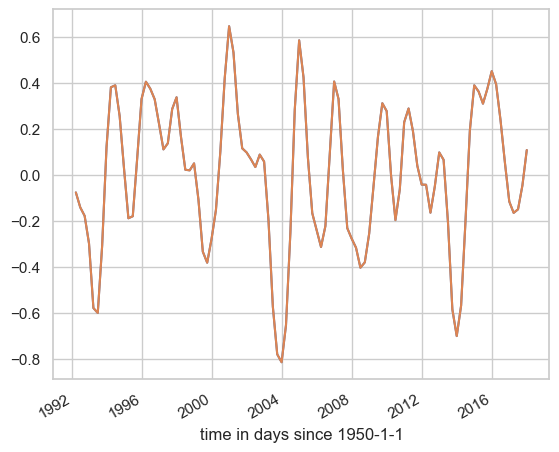

In [ ]:
# Deseasonalize with a uniform/average climatology

mlt_detrend_uniform_deseasonalize_uniform_ts = deseasonalize(mlt_detrend_uniform_ts)


climfit = obs23_melt_detrend_uniform_ts - mlt_detrend_uniform_deseasonalize_uniform_ts
obs23_melt_detrend_uniform_deseasonalize_uniform = obs23_melt_detrend_uniform - climfit

In [431]:
mlt_detrend = clip_data(obs23_melt_detrend_uniform, i)

# Deseasonalize
# Remove climatologies to isolate anomalies / deseasonalize
mlt_detrend_month = mlt_detrend.groupby("time.month")
mlt_detrend_clm = mlt_detrend_month.mean("time").compute() # Climatologies
mlt_detrend_anm = (mlt_detrend_month - mlt_detrend_clm).compute() # Deseasonalized anomalies



In [437]:
mlt_detrend_ts = mlt_detrend.mean(dim=['x', 'y']).compute()

In [439]:
mlt_detrend_clm_ts = mlt_detrend_ts - mlt_detrend_anm_ts

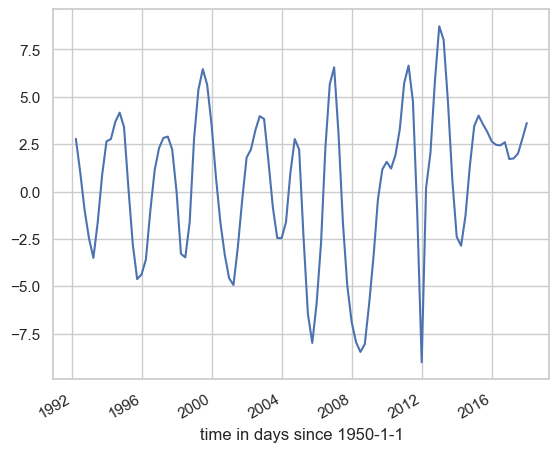

In [433]:
mlt_detrend_anm_ts = mlt_detrend_anm.mean(['x', 'y']).compute()
mlt_detrend_anm_ts.plot()

In [ ]:
i = 114
# obs23_melt_detrend_uniform_deseasonalize_uniform = obs23_melt_detrend_uniform_deseasonalize_uniform.melt

mlt = clip_data(obs23_melt_detrend_uniform_tm, i)
h = clip_data(obs23_draft_tm, i)

# Reshape mlt and h data for linear regression
mlt_stack = mlt.stack(z=('x', 'y'))#.values.reshape(-1,1)
h_stack = h.stack(z=('x', 'y'))#.values.reshape(-1,1)

mlt_stack_noNaN = mlt_stack.fillna(0)
h_stack_noNaN = h_stack.fillna(0)

mlt_stack_noNaN_vals = mlt_stack_noNaN.values.reshape(-1,1)
h_stack_noNaN_vals = h_stack_noNaN.values.reshape(-1,1)

# X is the independent variable, y is the dependent variable
# X is the ice draft, y is the melt rate
X = h_stack_noNaN_vals
y = mlt_stack_noNaN_vals
reg = LinearRegression().fit(X,y)
print("X is:")
print(X)
print("Shape of X is: {}".format(X.shape))
print("Coefficient (slope) is: ")
print(reg.coef_)
print("Intercept is: ")
print(reg.intercept_)
print("y is:")
print(y)
#print("Predicted y for X = [3,5] is:")
#print(reg.predict(np.array([[3,5]])))

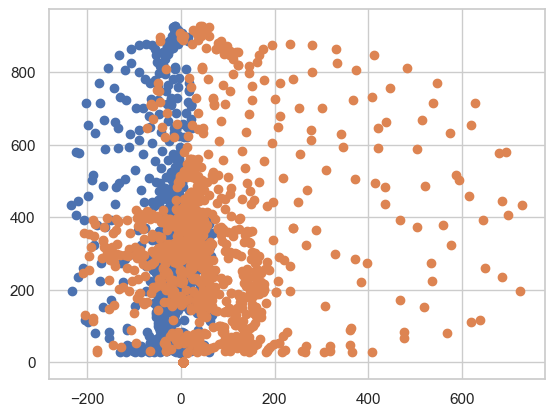

In [152]:
plt.scatter(mlt,h)
plt.scatter(model.predict(mlt_stack_noNaN_vals),h_stack_noNaN_vals)

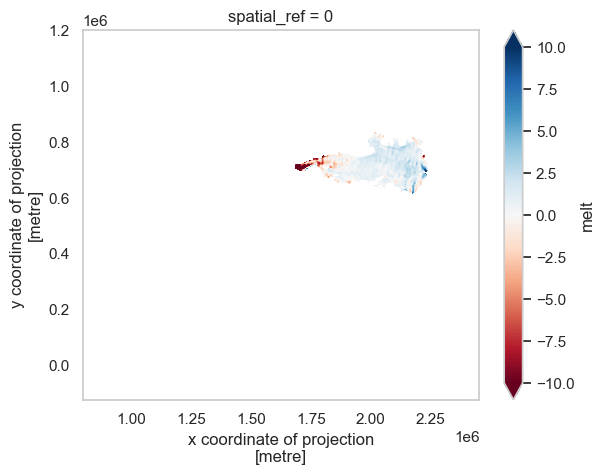

In [113]:
mlt.plot(vmin=-10, vmax=10, cmap='RdBu')

In [50]:
# Reshape the data to a 2D array in space and time to perform a linear regression
X = mlt.stack(z=('x', 'y')).values
X = X.transpose()
# y = h.values.reshape(-1,1)
y = h.stack(z=('x', 'y')).values
y = y.transpose()
#y = h.mean('time').values.reshape(-1,1)

In [55]:
X = mlt.values.reshape(-1,1)
y = h.values.reshape(-1,1)

In [88]:
X = h.mean('time').stack(z=('x', 'y')).values.reshape(-1,1)
y = mlt.mean('time').stack(z=('x', 'y')).values.reshape(-1,1)

model = LinearRegression().fit(X,y)

In [57]:
X = X.fillna(0)
#h = h.fillna(0)

AttributeError: 'numpy.ndarray' object has no attribute 'fillna'

In [58]:
model = LinearRegression().fit(np.nan_to_num(y),np.nan_to_num(X))

In [59]:
coeffs = model.coef_
intercept = model.intercept_

(194, 346)

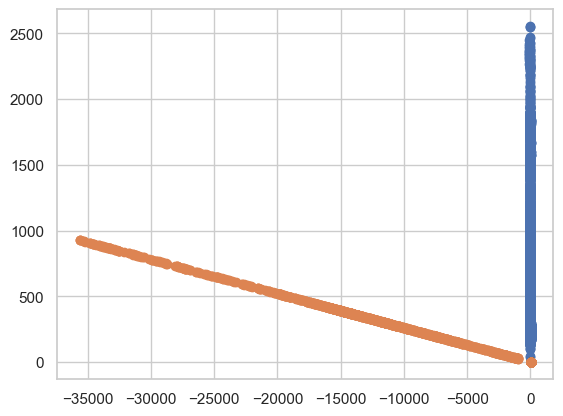

In [145]:
plt.scatter(mlt,h)
plt.scatter(model.predict(np.nan_to_num(y)),np.nan_to_num(y))

In [65]:
# mlt_dedraft = mlt - model.predict(X).reshape(h_tm.shape)

mlt_dedraft = mlt - model.predict(np.nan_to_num(X)).reshape(h.shape)

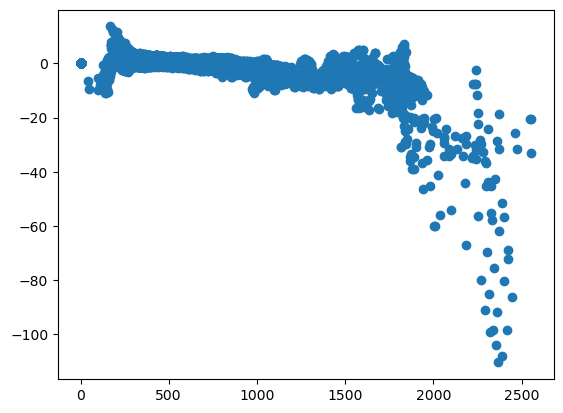

In [74]:
plt.scatter(h.values.reshape(-1),mlt_tm.values.reshape(-1))

In [18]:
def xr_regression(y):
    X = sm.add_constant(mlt_tm, prepend=True) # regressor matrix
    mod = sm.GLSAR(y.values, X, 2, missing = 'drop') # MLR analysis with AR2 modeling
    res = mod.iterative_fit()
    return xr.DataArray(res.params[1:])

In [ ]:
stacked = anomalies.stack(allpoints = ['lev', 'lat']).squeeze()
stacked = stacked.reset_coords(drop=True)
coefs = stacked.groupby('allpoints').apply(xr_regression)
coefs_unstacked = coefs.unstack('allpoints')

In [ ]:

# Dedraft: Linear Regression with SSH over chosen basin
print('calculating linear regression for catchment {}'.format(icems.name.values[i]))
mlt_rgrs = xr_linregress(h, mlt_tm) # h = independent variable
# Save the parameters/co-efficients of the linear regression function for each ice shelf as a NETCDF file
#mlt_rgrs.to_netcdf(main_dir / DIR_interim / 'dedraft/iceShelfRegions/{}_DEDRAFT_PARAMS.nc'.format(icems.name.values[i]))
#mlt_prd = mlt_rgrs.slope*SORRMv21_DRAFT_TMEAN + mlt_rgrs.intercept

In [ ]:
for i in iceShelfRegions:
    print('extracting data for catchment {}'.format(icems.name.values[i]))
    mlt = SORRMv21_DETREND_DESEASONALIZE_FLUX.rio.clip(icems.loc[[i],'geometry'].apply(mapping),icems.crs,drop=False)
    # mlt = MELTDRAFT_OBS.melt.rio.clip(icems.loc[[i],'geometry'].apply(mapping),icems.crs,drop=False)
    mlt_mean = mlt.mean(tdim)
    # Dedraft: Linear Regression with SSH over chosen basin
    print('calculating linear regression for catchment {}'.format(icems.name.values[i]))
    mlt_rgrs = xr_linregress(SORRMv21_DRAFT, mlt_mean, dim=tdim) # h = independent variable
    # Save the parameters/co-efficients of the linear regression function for each ice shelf as a NETCDF file
    mlt_rgrs.to_netcdf(main_dir / DIR_interim / 'dedraft/iceShelfRegions/{}_DEDRAFT_PARAMS.nc'.format(icems.name.values[i]))
    mlt_prd = mlt_rgrs.slope*SORRMv21_DRAFT_TMEAN + mlt_rgrs.intercept
    # flx_ddrft = flx - flx_prd
    # Save the linear regression function fit of the melt flux over each ice shelf as a NETCDF file
    # The dedrafted melt flux is calculated as the difference between the actual melt flux and the predicted melt flux, done in the next merge_dedraft_data.py step.
    mlt_prd.to_netcdf(main_dir / DIR_interim / 'dedraft/iceShelfRegions/{}_DEDRAFT_REGRESS.nc'.format(icems.name.values[i]))
    print('{} file saved'.format(icems.name.values[i]))
    del mlt, mlt_mean, mlt_rgrs, mlt_prd
    print('deleted interim variables')
    gc.collect()

In [88]:
IMBIEregions = range(6,33)
iceShelfRegions = range(33,133)

iceShelfRegions = range(6,16)

for i in iceShelfRegions:
    print('extracting data for catchment {}'.format(icems.name.values[i]))
    mltanm = clip_data(obs23_melt_tm, i)
    z = clip_data(obs23_draft_tm, i)
    plt.scatter(mltanm, z, marker='x', s=3)
    plt.ylim(2500,0)
    del mltanm, z
    print('deleted interim variables')
    gc.collect()

extracting data for catchment IMBIE1


MissingCRS: CRS not found. Please set the CRS with 'rio.write_crs()'. Data variable: melt

In [ ]:
# will need to use relative drafts here?